## Description:

Conducts DMD analysis on time series data. Plots the eigenmodes, eigenvalues anda attempts to preduct next time step using the learned modes.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml

from FLAME.io_fields import field_path, FIELD_HDF_KEY
from FLAME.io_fronts import Case
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD
from mpi4py import MPI


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/DMD" / "DMD.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

# Input Parameters (from YAML)
# ============================================================
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])  # where extracted_field[_post]_{t}.hdf5 were saved
if BASE_DIR.name != "unstructured" and (BASE_DIR / "unstructured").exists():
    BASE_DIR = BASE_DIR / "unstructured"

VAR_NAME = str(CFG["VAR_NAME"])  # field to run DMD on
SORT_COLS = list(CFG["SORT_COLS"])  # stable ordering key for the state vector
COORD_TOL = float(CFG["COORD_TOL"])  # set to >0 (e.g. 1e-12) if you want tolerance checks

# Remove temporal mean before DMD
REMOVE_MEAN = bool(CFG.get("REMOVE_MEAN", False))

# Cropping: keep only points with x > X_THESHOLD
X_THESHOLD = float(CFG["X_THRESHOLD"])

REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUT_DIR"])

PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"

if TIME_STEP_START == TIME_STEP_END:
    TIME_TAG = f"t_{TIME_STEP_START}"
else:
    TIME_TAG = f"t_{TIME_STEP_START}_to_{TIME_STEP_END}"

OUT_DIR = REPORT_BASE_DIR / PHI_TAG / LAT_TAG / TIME_TAG

# Optional: limit number of modes via truncated SVD (null = no limit)
DMD_SVD_RANK = CFG.get("DMD_SVD_RANK", None)


# Helpers: locate + read the FULL FIELD HDF5 (NO iso)
# ============================================================

def field_hdf5_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, var_name: str, sort_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      coords: (n_points, len(sort_cols)) array of coordinates (sorted)
      values: (n_points,) array of var_name values (sorted same way)
    """
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")

    df = pd.read_hdf(path, key=FIELD_HDF_KEY)

    missing = [c for c in (sort_cols + [var_name]) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + [var_name])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    coords = df[sort_cols].to_numpy(dtype=np.float64)
    values = df[var_name].to_numpy(dtype=np.float64)
    return coords, values



In [3]:
# Build snapshot matrix X for DMD (NO interpolation)
# ============================================================

comm = MPI.COMM_WORLD
rank = comm.rank

times = list(range(TIME_STEP_START, TIME_STEP_END + 1))

# Read reference timestep (FULL, then build mask from it)
ref_path = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
coords_ref_full, snap0_full = read_field_sorted(ref_path, VAR_NAME, SORT_COLS)

# Apply x-threshold mask ONCE, then apply same mask to all timesteps
x_ref = coords_ref_full[:, 0]
mask_x = x_ref > X_THESHOLD

coords_ref = coords_ref_full[mask_x]
snap0 = snap0_full[mask_x]

n_points = coords_ref.shape[0]
n_snapshots = len(times)

if rank == 0:
    print(f"Reference timestep: {times[0]}")
    print(f"X_THESHOLD={X_THESHOLD} -> keeping {n_points}/{coords_ref_full.shape[0]} points")
    print(f"n_points={n_points}, n_snapshots={n_snapshots}")
    print(f"Reading: {ref_path}")

snapshots = [snap0]

# Read remaining timesteps, verify identical FULL coordinates, then apply same mask
for t in times[1:]:
    path = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"Inconsistent number of points (full) at timestep {t}: {coords_t_full.shape[0]} vs {coords_ref_full.shape[0]}"
            f"Interpolation (or re-meshing to a common grid) would be required."
        )

    # Coordinate consistency check on FULL coords
    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Coordinates do not match reference at timestep {t}"
            f"Set COORD_TOL>0 to allow tolerance, or use interpolation onto a common grid."
        )

    # Apply same mask
    snap_t = snap_t_full[mask_x]
    snapshots.append(snap_t)

# Snapshot matrix: shape (n_state, n_snapshots)
X = np.stack(snapshots, axis=1)

if REMOVE_MEAN:
    X_mean = np.mean(X, axis=1, keepdims=True)
    X_dmd_mean = X - X_mean
else:
    X_mean = np.zeros((X.shape[0], 1), dtype=X.dtype)
    X_dmd_mean = X

X_dmd_raw = X

if rank == 0:
    print("X shape:", X.shape)

# DMD (fit both mean-extracted and raw cases)
# ============================================================

if REMOVE_MEAN:
    CASE_INFO = [
        {"key": "mean_extracted", "remove_mean": True, "label": "mean extracted"},
        {"key": "no_mean_extracted", "remove_mean": False, "label": "no mean extracted"},
    ]
else:
    CASE_INFO = [
        {"key": "no_mean_extracted", "remove_mean": False, "label": "no mean extracted"},
    ]

CASE_ORDER = [case["key"] for case in CASE_INFO]
CASE_LABELS = {case["key"]: case["label"] for case in CASE_INFO}
CASE_REMOVE_MEAN = {case["key"]: case["remove_mean"] for case in CASE_INFO}

dmd_by_case = {}
for case in CASE_INFO:
    label = case["label"]
    if rank == 0:
        print(f"Now training DMD with {label}")
    X_dmd_case = X_dmd_mean if case["remove_mean"] else X_dmd_raw
    if DMD_SVD_RANK is None:
        dmd_case = DMD()
    else:
        dmd_case = DMD(svd_rank=int(DMD_SVD_RANK))
    dmd_case.fit(X_dmd_case)
    dmd_by_case[case["key"]] = dmd_case

DEFAULT_CASE_KEY = "mean_extracted" if REMOVE_MEAN else "no_mean_extracted"
dmd = dmd_by_case[DEFAULT_CASE_KEY]
X_dmd = X_dmd_mean if REMOVE_MEAN else X_dmd_raw





Reference timestep: 270
X_THESHOLD=320.0 -> keeping 204544/839680 points
n_points=204544, n_snapshots=21
Reading: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/unstructured/phi0.40/h400x025_ref/extracted_field_270.hdf5
X shape: (204544, 21)
Now training DMD with no mean extracted


[SVD energy] threshold 0.90 -> r = 1
[SVD energy] threshold 0.95 -> r = 1
[SVD energy] threshold 0.99 -> r = 1


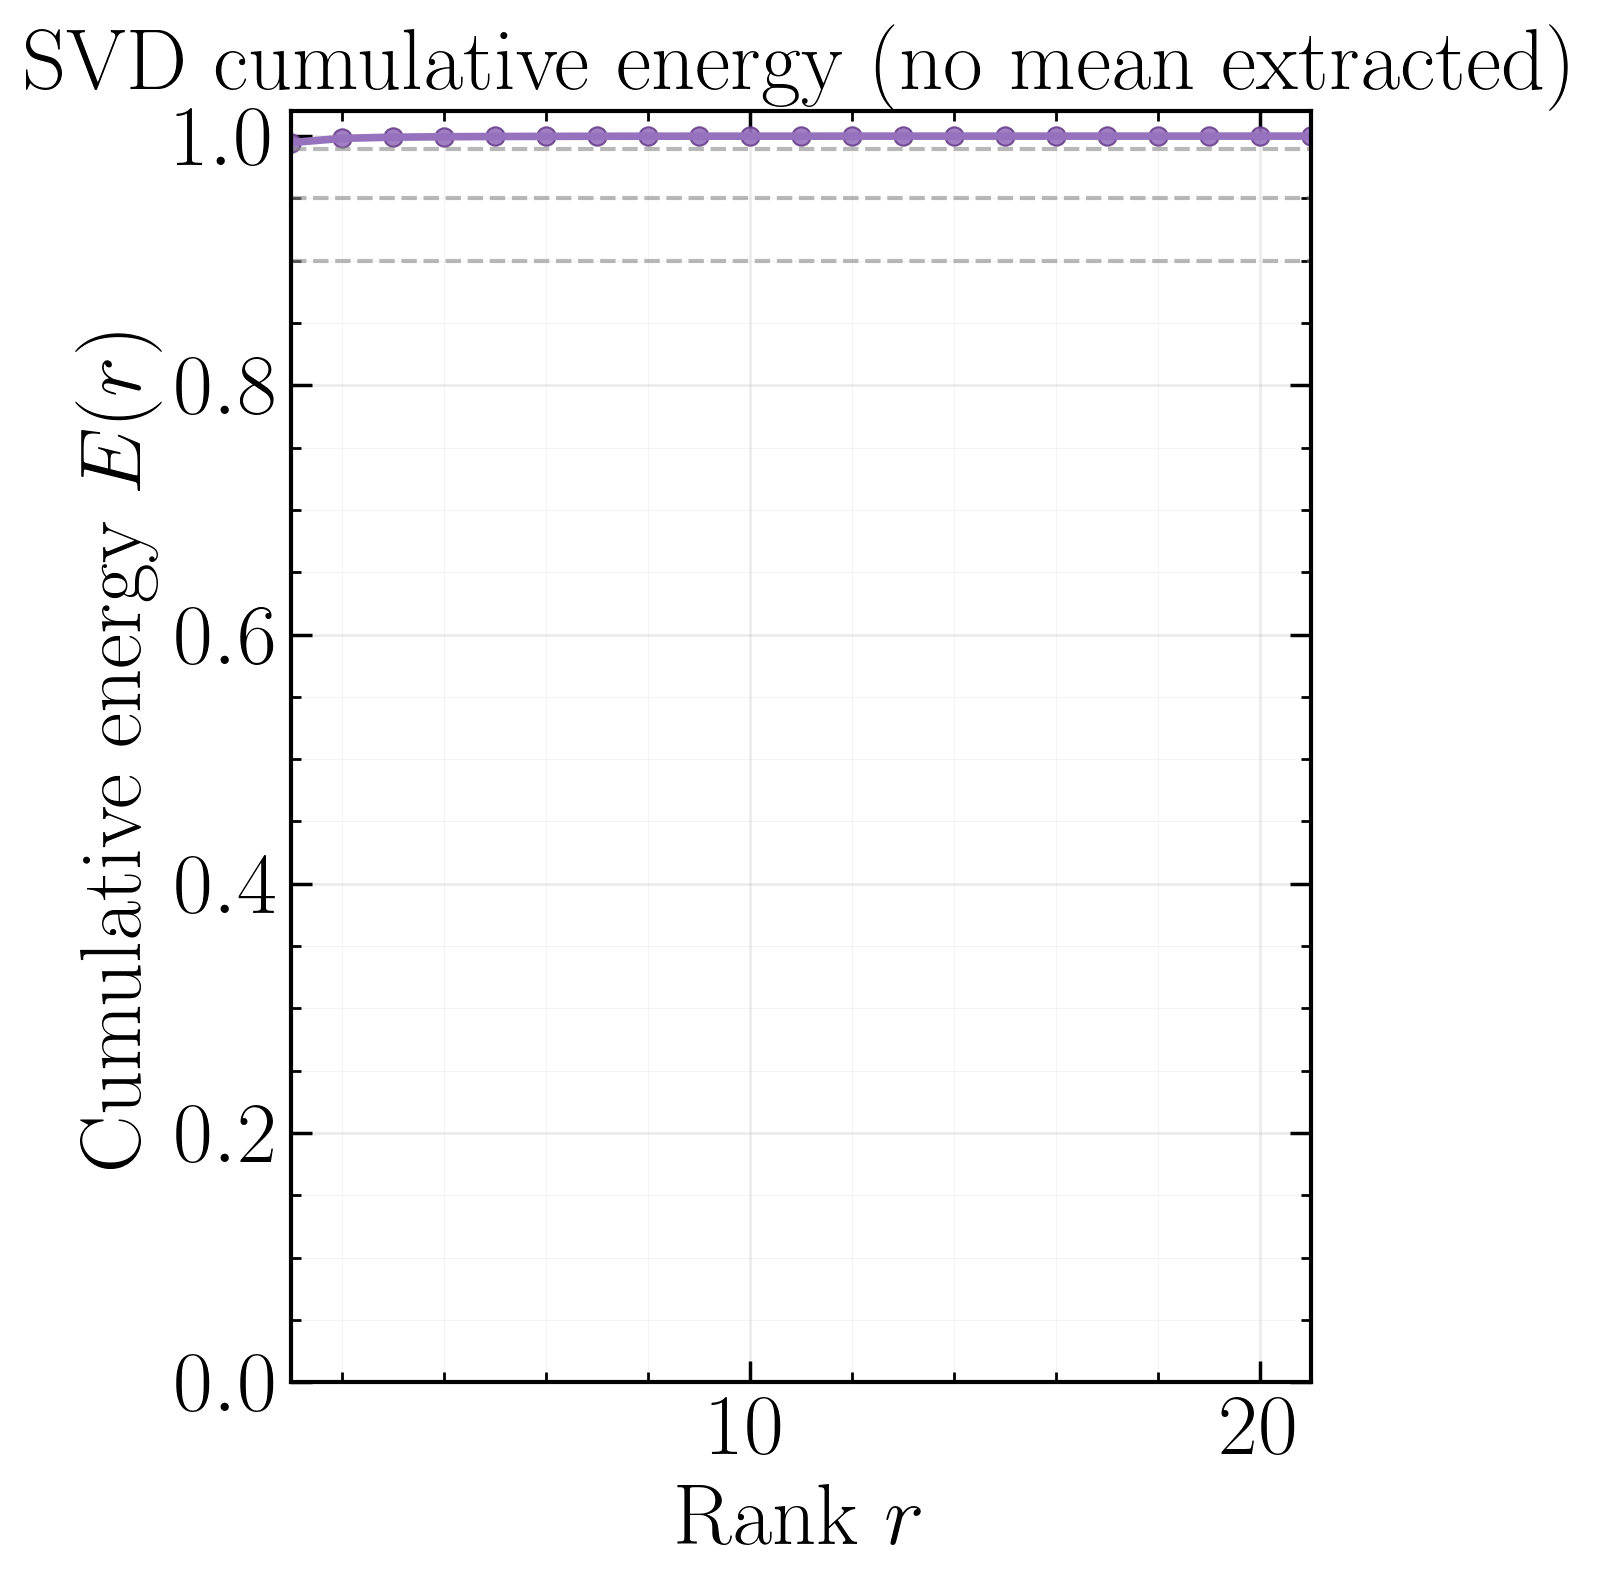

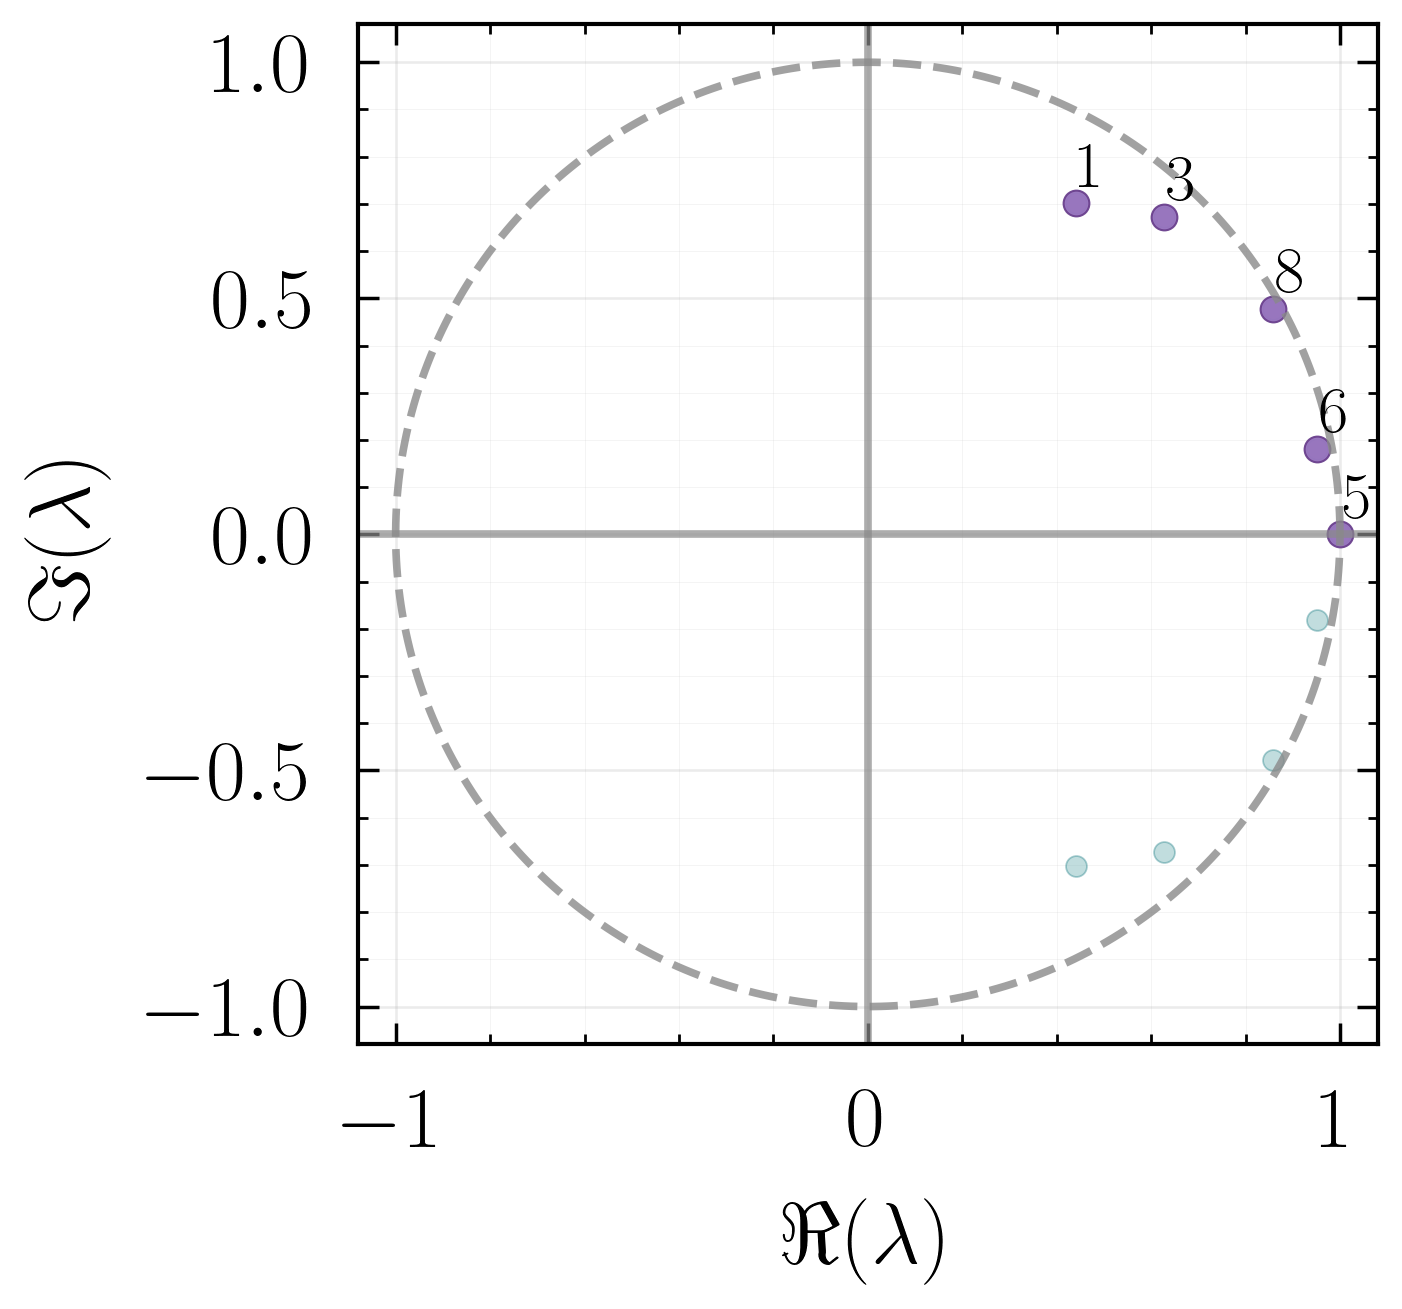

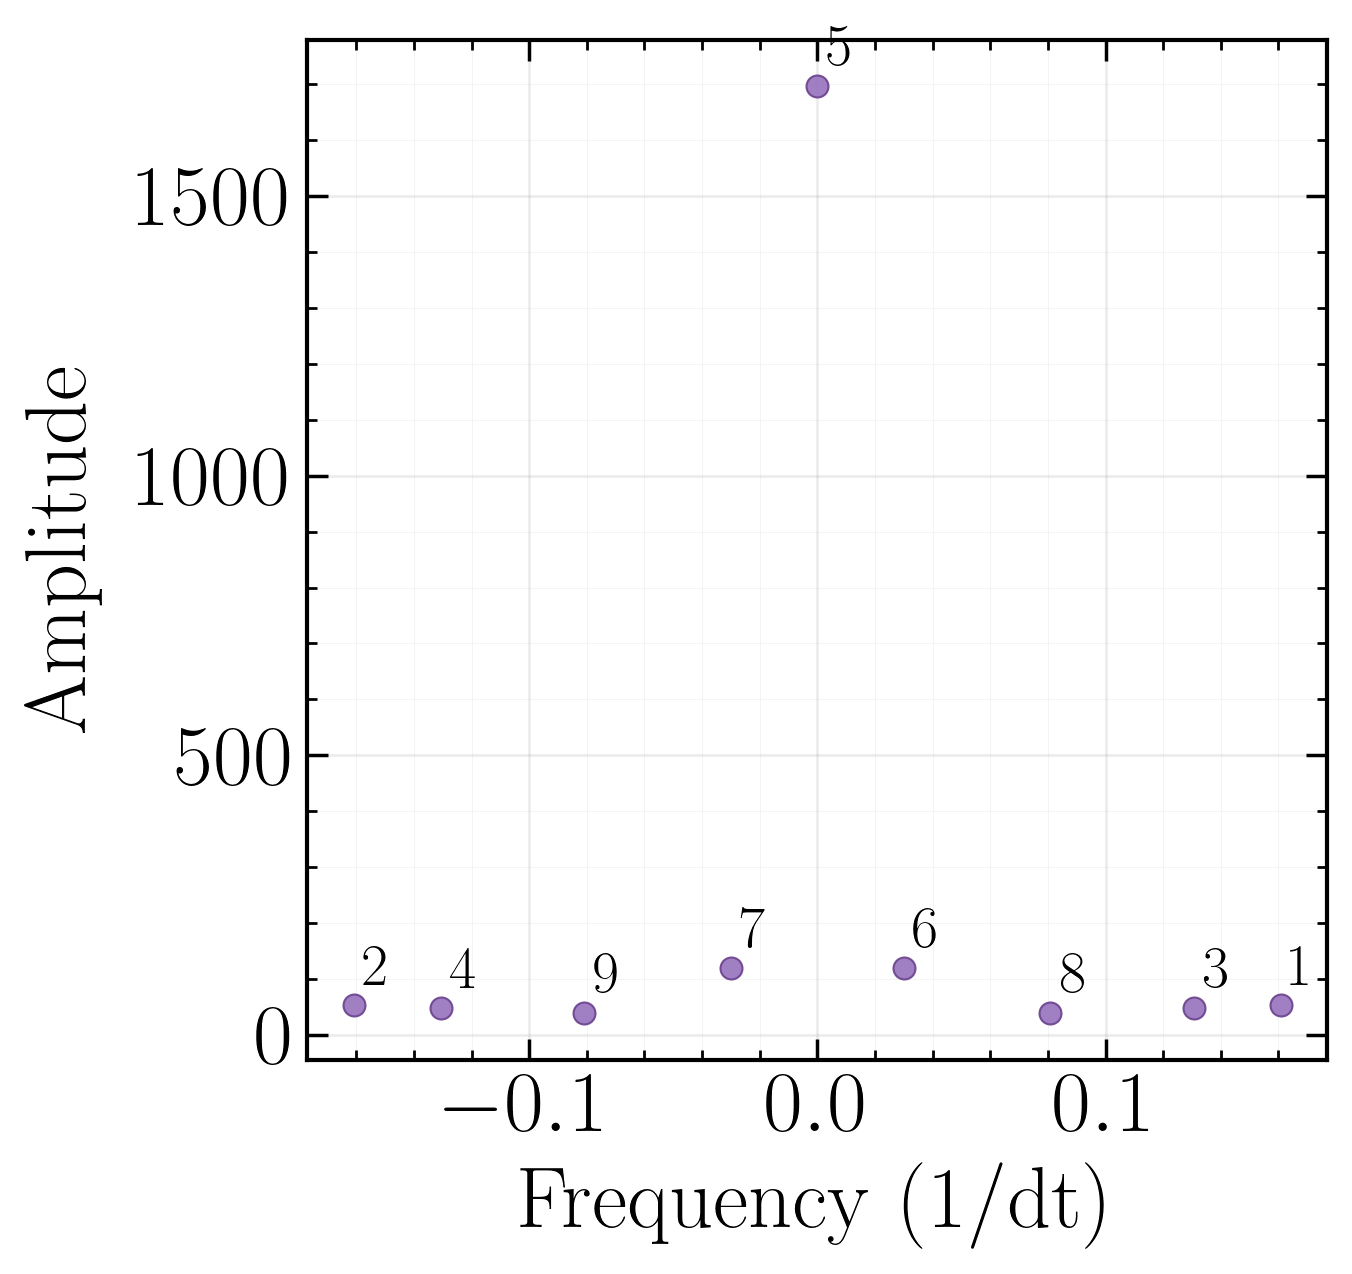

In [4]:

# Output directory 
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# PLOT STYLE (template-based)
# ============================================================
import matplotlib.pyplot as plt
PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
        "figure.subplot.left": 0.14,
        "figure.subplot.right": 0.86,
        "figure.subplot.bottom": 0.14,
        "figure.subplot.top": 0.96,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()


MARKER_SIZE = float(CFG.get("PLOT_MARKER_SIZE", 6.0))
PLOT_PAD = float(CFG.get("PLOT_PAD", 0.02))

PLOT_FORMATS = CFG.get("PLOT_FORMATS", ["png", "pdf"])
if isinstance(PLOT_FORMATS, str):
    PLOT_FORMATS = [PLOT_FORMATS]
PLOT_FORMATS = [str(x).lower().lstrip('.') for x in PLOT_FORMATS]


def new_fig(*, figsize=None, dpi=None):
    fig, ax = plt.subplots(figsize=figsize or FIG_SIZE, dpi=dpi or FIG_DPI)
    return fig, ax


def save_plot(fig, stem: str, out_dir=None) -> None:
    if out_dir is None:
        out_dir = OUT_DIR if "OUT_DIR" in globals() else None
    if out_dir is None:
        return
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for ext in PLOT_FORMATS:
        if ext == "png":
            fig.savefig(out_dir / f"{stem}.png", dpi=FIG_DPI)
        elif ext == "pdf":
            fig.savefig(out_dir / f"{stem}.pdf")
        elif ext == "svg":
            fig.savefig(out_dir / f"{stem}.svg")

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




LINE_WIDTH = float(CFG.get("PLOT_LINE_WIDTH", 2.2))
def style_colorbar(cbar, *, nbins: int = 5) -> None:
    from matplotlib.ticker import MaxNLocator
    cbar.ax.tick_params(labelsize=PLOT_FONT_SIZE - 6)
    cbar.locator = MaxNLocator(nbins=nbins)
    cbar.update_ticks()

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        style_axes(ax)
def annotate_no_overlap(
    ax,
    xs,
    ys,
    labels,
    *,
    min_sep=0.025,
    fontsize=None,
    fontweight=None,
) -> None:
    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)

    if xs.size == 0:
        return

    x_span = float(np.ptp(xs)) or 1.0
    y_span = float(np.ptp(ys)) or 1.0

    offsets = [
        (0.01, 0.01),
        (0.01, -0.01),
        (-0.01, 0.01),
        (-0.01, -0.01),
        (0.02, 0.0),
        (-0.02, 0.0),
        (0.0, 0.02),
        (0.0, -0.02),
        (0.03, 0.03),
        (0.03, -0.03),
        (-0.03, 0.03),
        (-0.03, -0.03),
    ]

    placed = []
    for x, y, label in zip(xs, ys, labels):
        best = None
        for ox, oy in offsets:
            tx = x + ox * x_span
            ty = y + oy * y_span
            if all((abs(tx - px) > min_sep * x_span) or (abs(ty - py) > min_sep * y_span) for px, py in placed):
                best = (tx, ty)
                break
        if best is None:
            best = (x + 0.04 * x_span, y + 0.04 * y_span)
        ax.text(
            best[0],
            best[1],
            str(label),
            fontsize=fontsize or (PLOT_FONT_SIZE - 8),
            fontweight=fontweight,
            ha="left",
            va="bottom",
        )
        placed.append(best)



def plot_dmd_eigs_report(
    dmd,
    VAR_NAME="field",
    OUT_DIR=None,          # pathlib.Path or None
    stem="dmd_eigs_complex_plane",
    label_top_n=12,        # label only the most "important" modes to avoid clutter
    MODE_IMAG_TOL=1e-10,
    use_amp_rms_for_labels=True,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    # Optional importance metric for labeling
    if use_amp_rms_for_labels and hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amp_rms = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amp_rms = np.ones(len(lam))

    # Keep one per conjugate pair: real + upper half-plane
    indices_keep = []
    for i, li in enumerate(lam):
        if li.imag > MODE_IMAG_TOL:
            indices_keep.append(i)
        elif abs(li.imag) <= MODE_IMAG_TOL:
            indices_keep.append(i)
    indices_keep = np.array(indices_keep, dtype=int)

    # Choose which indices to annotate (top-N by amp_rms among kept)
    order = indices_keep[np.argsort(amp_rms[indices_keep])[::-1]]
    idx_annot = order[:min(label_top_n, len(order))]

    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(left=0.22, right=0.82)
    ax = fig.add_subplot(111)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.8)

    # Axes lines
    ax.axhline(0.0, linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.7)
    ax.axvline(0.0, linewidth=LINE_WIDTH, color=COLOR_LINE, alpha=0.7)

    # Plot all eigenvalues (light)
    ax.scatter(lam.real, lam.imag, s=36, alpha=0.45, color=COLOR_DATA, edgecolors=COLOR_DATA_EDGE, linewidths=0.5)

    # Highlight kept (one per conj. pair)
    ax.scatter(lam[indices_keep].real, lam[indices_keep].imag, s=55, alpha=0.95, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    # Annotate selected modes only (avoid clutter)
    xs = lam[idx_annot].real
    ys = lam[idx_annot].imag
    labels = [k + 1 for k in idx_annot]
    annotate_no_overlap(ax, xs, ys, labels, min_sep=0.03, fontsize=PLOT_FONT_SIZE - 6, fontweight="bold")

    ax.tick_params(axis="both", which="both", pad=12)
    ax.set_xlabel(r"$\Re(\lambda)$", labelpad=10)
    ax.set_ylabel(r"$\Im(\lambda)$", labelpad=10)
    style_axes(ax)

    # Limits: slightly padded around points + unit circle
    rmax = max(1.0, np.max(np.abs(lam)) if len(lam) else 1.0)
    lim = 1.08 * rmax
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect("equal", adjustable="box")
    style_axes(ax)


    # Save if requested
    save_plot(fig, stem, OUT_DIR)

    plt.show()
def plot_dmd_amp_vs_freq(
    dmd,
    *,
    OUT_DIR=None,
    stem="dmd_amp_vs_freq",
    dt=None,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    if dt is None:
        if hasattr(dmd, "dmd_time") and "dt" in dmd.dmd_time:
            dt = float(dmd.dmd_time["dt"])
        else:
            dt = 1.0

    if hasattr(dmd, "amplitudes") and dmd.amplitudes is not None:
        amps = np.abs(np.asarray(dmd.amplitudes))
    elif hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amps = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amps = np.ones(len(lam))

    omega = np.log(lam) / dt
    freq = omega.imag / (2 * np.pi)

    valid = np.isfinite(freq) & np.isfinite(amps)
    valid_idx = np.nonzero(valid)[0]
    freq = freq[valid]
    amps = amps[valid]

    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(left=0.22, right=0.82)
    ax = fig.add_subplot(111)
    ax.scatter(freq, amps, s=40, alpha=0.9, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    labels = [idx + 1 for idx in valid_idx]
    annotate_no_overlap(ax, freq, amps, labels, min_sep=0.025, fontsize=PLOT_FONT_SIZE - 8)
    ax.set_xlabel("Frequency (1/dt)" if CFG.get("DT", None) is None else "Frequency (Hz)")
    ax.set_ylabel("Amplitude", labelpad=10)
    ax.set_box_aspect(1)  # match dmd eigs plot box dimensions
    style_axes(ax)

    save_plot(fig, stem, OUT_DIR)

    plt.show()
    return fig

def plot_dmd_amp_vs_freq(
    dmd,
    *,
    OUT_DIR=None,
    stem="dmd_amp_vs_freq",
    dt=None,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    if dt is None:
        if hasattr(dmd, "dmd_time") and "dt" in dmd.dmd_time:
            dt = float(dmd.dmd_time["dt"])
        else:
            dt = 1.0

    if hasattr(dmd, "amplitudes") and dmd.amplitudes is not None:
        amps = np.abs(np.asarray(dmd.amplitudes))
    elif hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amps = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amps = np.ones(len(lam))

    omega = np.log(lam) / dt
    freq = omega.imag / (2 * np.pi)

    valid = np.isfinite(freq) & np.isfinite(amps)
    valid_idx = np.nonzero(valid)[0]
    freq = freq[valid]
    amps = amps[valid]

    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(left=0.22, right=0.82)
    ax = fig.add_subplot(111)
    ax.scatter(freq, amps, s=40, alpha=0.9, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    labels = [idx + 1 for idx in valid_idx]
    annotate_no_overlap(ax, freq, amps, labels, min_sep=0.025, fontsize=PLOT_FONT_SIZE - 8)
    ax.set_xlabel("Frequency (1/dt)" if CFG.get("DT", None) is None else "Frequency (Hz)")
    ax.set_ylabel("Amplitude", labelpad=10)
    ax.set_box_aspect(1)  # match dmd eigs plot box dimensions
    style_axes(ax)

    save_plot(fig, stem, OUT_DIR)

    plt.show()
    return fig



# ============================================================
# SVD ENERGY (rank-selection aid)
# ============================================================

def plot_svd_cumulative_energy(
    X_case: np.ndarray,
    *,
    OUT_DIR=None,
    stem: str = "svd_cumulative_energy",
    title: str | None = None,
    show_thresholds=(0.90, 0.95, 0.99),
    svd_rank: int | None = None,
):
    """Plot cumulative POD/SVD energy of the snapshot matrix.

    Energy definition: E(r) = sum_{i<=r} sigma_i^2 / sum_i sigma_i^2.
    For tall-skinny X (n_state x n_snapshots), this is cheap and robust.
    """
    # Singular values (no need to keep U, Vh)
    _, s, _ = np.linalg.svd(X_case, full_matrices=False)
    energy = (s ** 2).astype(float)
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-300)
    r = np.arange(1, len(s) + 1)

    # Print suggested ranks for common thresholds
    for thr in show_thresholds:
        ridx = int(np.searchsorted(cum, thr) + 1)
        if ridx <= len(s):
            print(f"[SVD energy] threshold {thr:.2f} -> r = {ridx}")

    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(left=0.22, right=0.82)
    ax = fig.add_subplot(111)
    ax.plot(r, cum, linewidth=LINE_WIDTH, color=COLOR_PRED)
    ax.scatter(r, cum, s=28, alpha=0.9, color=COLOR_PRED, edgecolors=COLOR_PRED_EDGE, linewidths=0.6)

    for thr in show_thresholds:
        ax.axhline(float(thr), linewidth=1.2, linestyle="--", color=COLOR_LINE, alpha=0.6)

    if svd_rank is not None:
        ax.axvline(int(svd_rank), linewidth=1.6, linestyle="-.", color=COLOR_DATA_EDGE, alpha=0.9)

    ax.set_xlabel("Rank $r$")
    ax.set_ylabel(r"Cumulative energy $E(r)$")
    ax.set_ylim(0.0, 1.02)
    ax.set_xlim(1, len(s))
    if title:
        ax.set_title(title)
    style_axes(ax)

    save_plot(fig, stem, OUT_DIR)

    plt.show()
    return fig

# --- energy plot per case (raw vs mean-extracted) ---
for case_key in CASE_ORDER:
    case_out_dir = OUT_DIR / case_key
    label = CASE_LABELS.get(case_key, case_key)
    X_case = X_dmd_mean if CASE_REMOVE_MEAN[case_key] else X_dmd_raw
    plot_svd_cumulative_energy(
        X_case,
        OUT_DIR=case_out_dir,
        stem=f"svd_cum_energy_{VAR_NAME}",
        title=f"SVD cumulative energy ({label})",
        svd_rank=DMD_SVD_RANK,
    )


# --- usage (consistent with your previous saving approach) ---
for case_key in CASE_ORDER:
    case_out_dir = OUT_DIR / case_key
    plot_dmd_eigs_report(
        dmd_by_case[case_key],
        VAR_NAME=VAR_NAME,
        OUT_DIR=case_out_dir,
        stem=f"dmd_eigs_{VAR_NAME}",
        label_top_n=12,
    )

    plot_dmd_amp_vs_freq(
        dmd_by_case[case_key],
        OUT_DIR=case_out_dir,
        stem="dmd_amp_vs_freq",
        dt=CFG.get("DT", None),
    )



In [5]:
for case_key in CASE_ORDER:
    dmd_case = dmd_by_case[case_key]
    label = CASE_LABELS.get(case_key, case_key)
    print(f"[{label}] DMD eigenvalues:", dmd_case.eigs)
    print(f"[{label}] modes shape:", dmd_case.modes.shape)
    print(f"[{label}] dynamics shape:", dmd_case.dynamics.shape)



[no mean extracted] DMD eigenvalues: [0.44053839+0.70280593j 0.44053839-0.70280593j 0.62779513+0.67328088j
 0.62779513-0.67328088j 1.00013113+0.j         0.9515272 +0.1818088j
 0.9515272 -0.1818088j  0.85813809+0.47780463j 0.85813809-0.47780463j]
[no mean extracted] modes shape: (204544, 9)
[no mean extracted] dynamics shape: (9, 21)


In [6]:
DT = CFG["DT"]

MODE_IMAG_TOL = float(CFG["MODE_IMAG_TOL"])
FREQ_TOL = float(CFG["FREQ_TOL"])

N_MODES_TO_PLOT = int(CFG["N_MODES_TO_PLOT"])

NORMALIZE_MODE_FOR_PLOT = bool(CFG["NORMALIZE_MODE_FOR_PLOT"])

CONTOUR_LEVELS_FILLED = int(CFG["CONTOUR_LEVELS_FILLED"])
CONTOUR_LEVELS_LINES = int(CFG["CONTOUR_LEVELS_LINES"])
MODE_CONTOUR_LEVELS_FILLED = int(CFG.get("MODE_CONTOUR_LEVELS_FILLED", min(CONTOUR_LEVELS_FILLED, 20)))

COORD_X = str(CFG["COORD_X"])
COORD_Y = str(CFG["COORD_Y"])

XLIM = CFG["XLIM"]
YLIM = CFG["YLIM"]
# -------------------------



### Predict next time step

[no mean extracted] BC metrics: dirichlet_left_rmse=2.387e-04, dirichlet_left_std=5.299e-14, neumann_right_rms=4.044e-04, periodic_top_bottom_rms=2.920e-14
[no mean extracted] Unstable modes (|λ|>1): 1
[no mean extracted] Max |λ|: 1.0001311346566697
[no mean extracted] Wrote: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/unstructured/phi0.40/h400x025_ref/dmd_pred_T_291_xgt320_no_mean_extracted.csv
[no mean extracted] Plotting modes: [5, 6, 8, 3, 1]


/tmp/ipykernel_13769/823386022.py:246: UserWarning: linewidths is ignored by contourf
  cf = ax.tricontourf(tri, mode_plot, levels=mode_levels, vmin=vmin_mode, vmax=vmax_mode, antialiased=False, linewidths=0)
/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772a64471bb0>' will be ignored
  cf.set_rasterized(True)


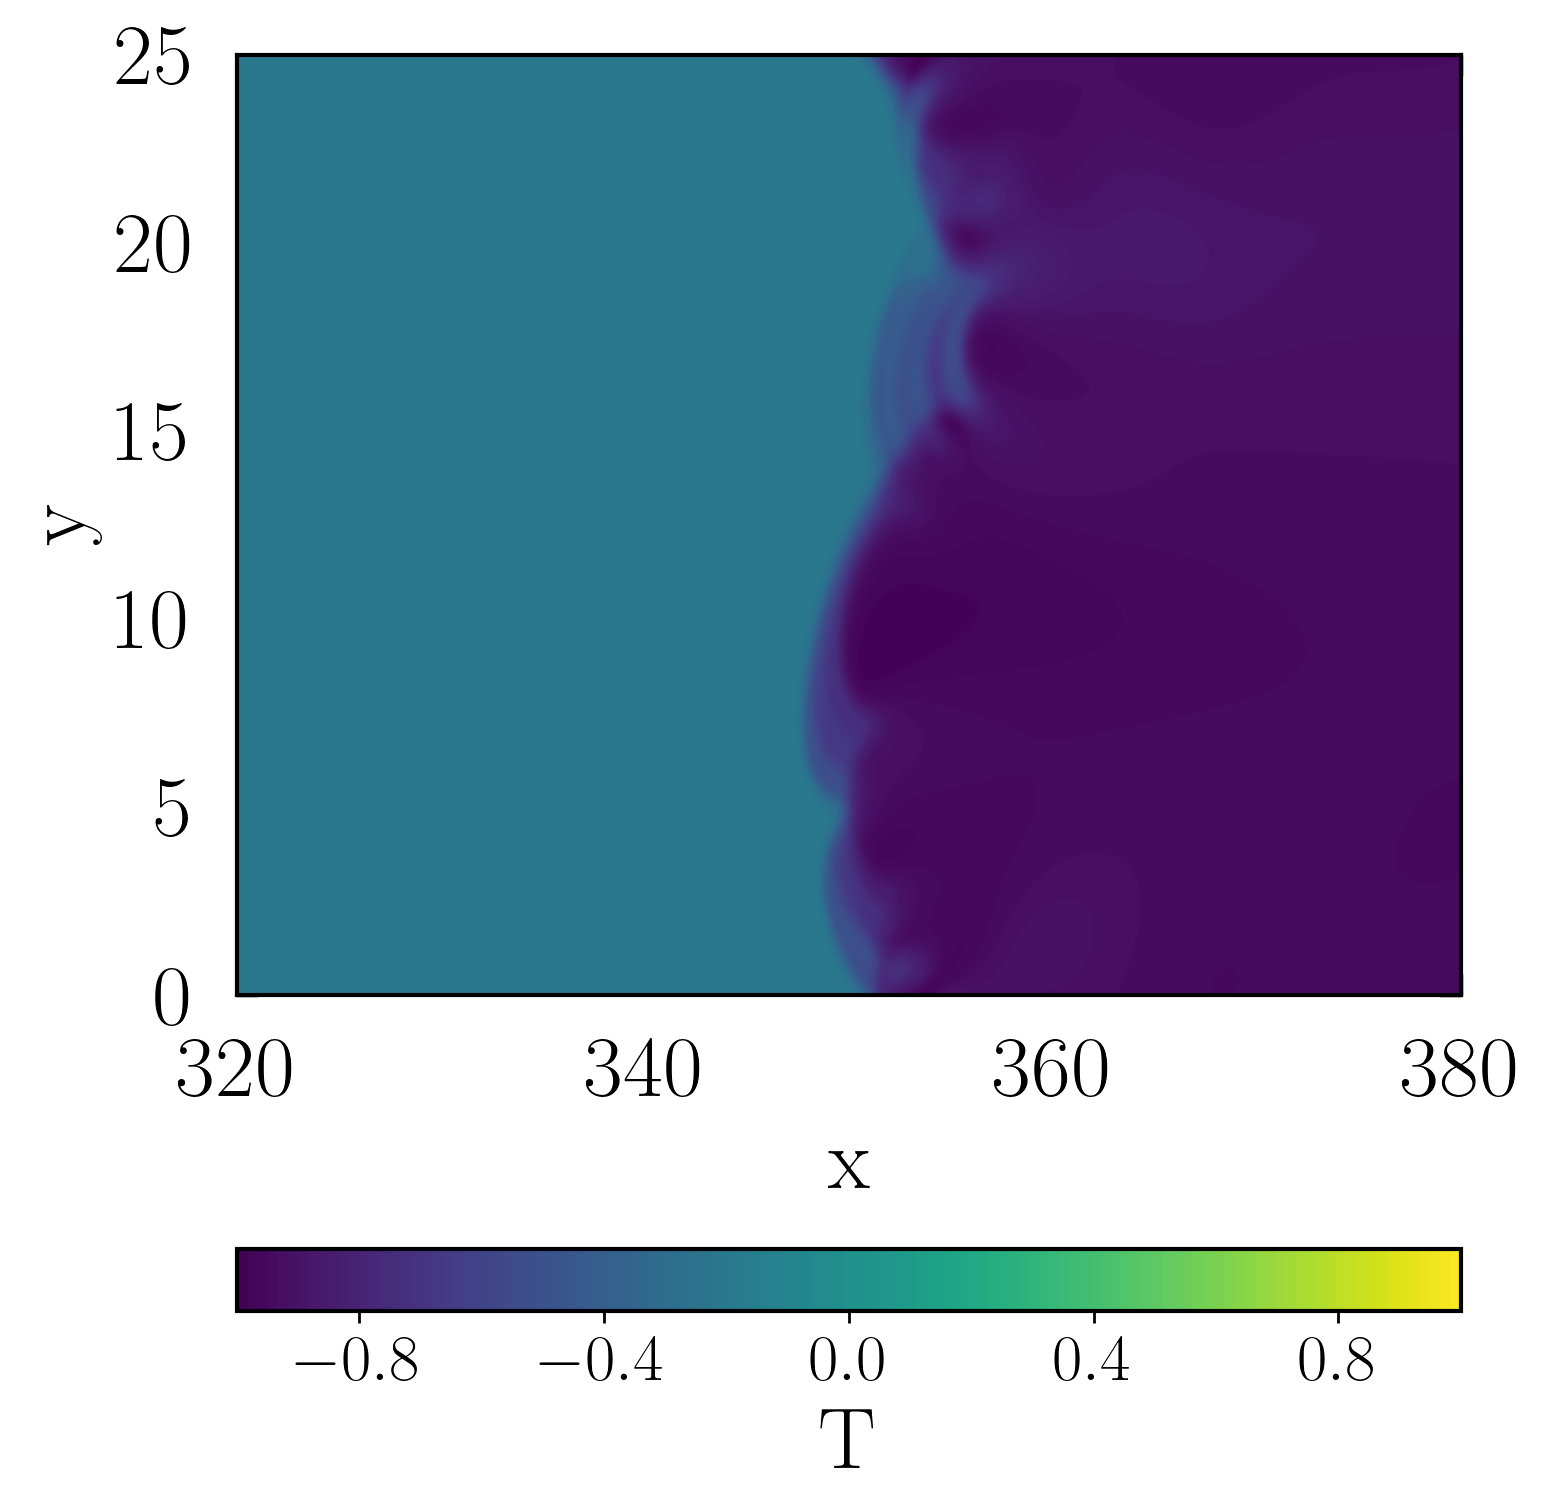

/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772a68d72f30>' will be ignored
  cf.set_rasterized(True)


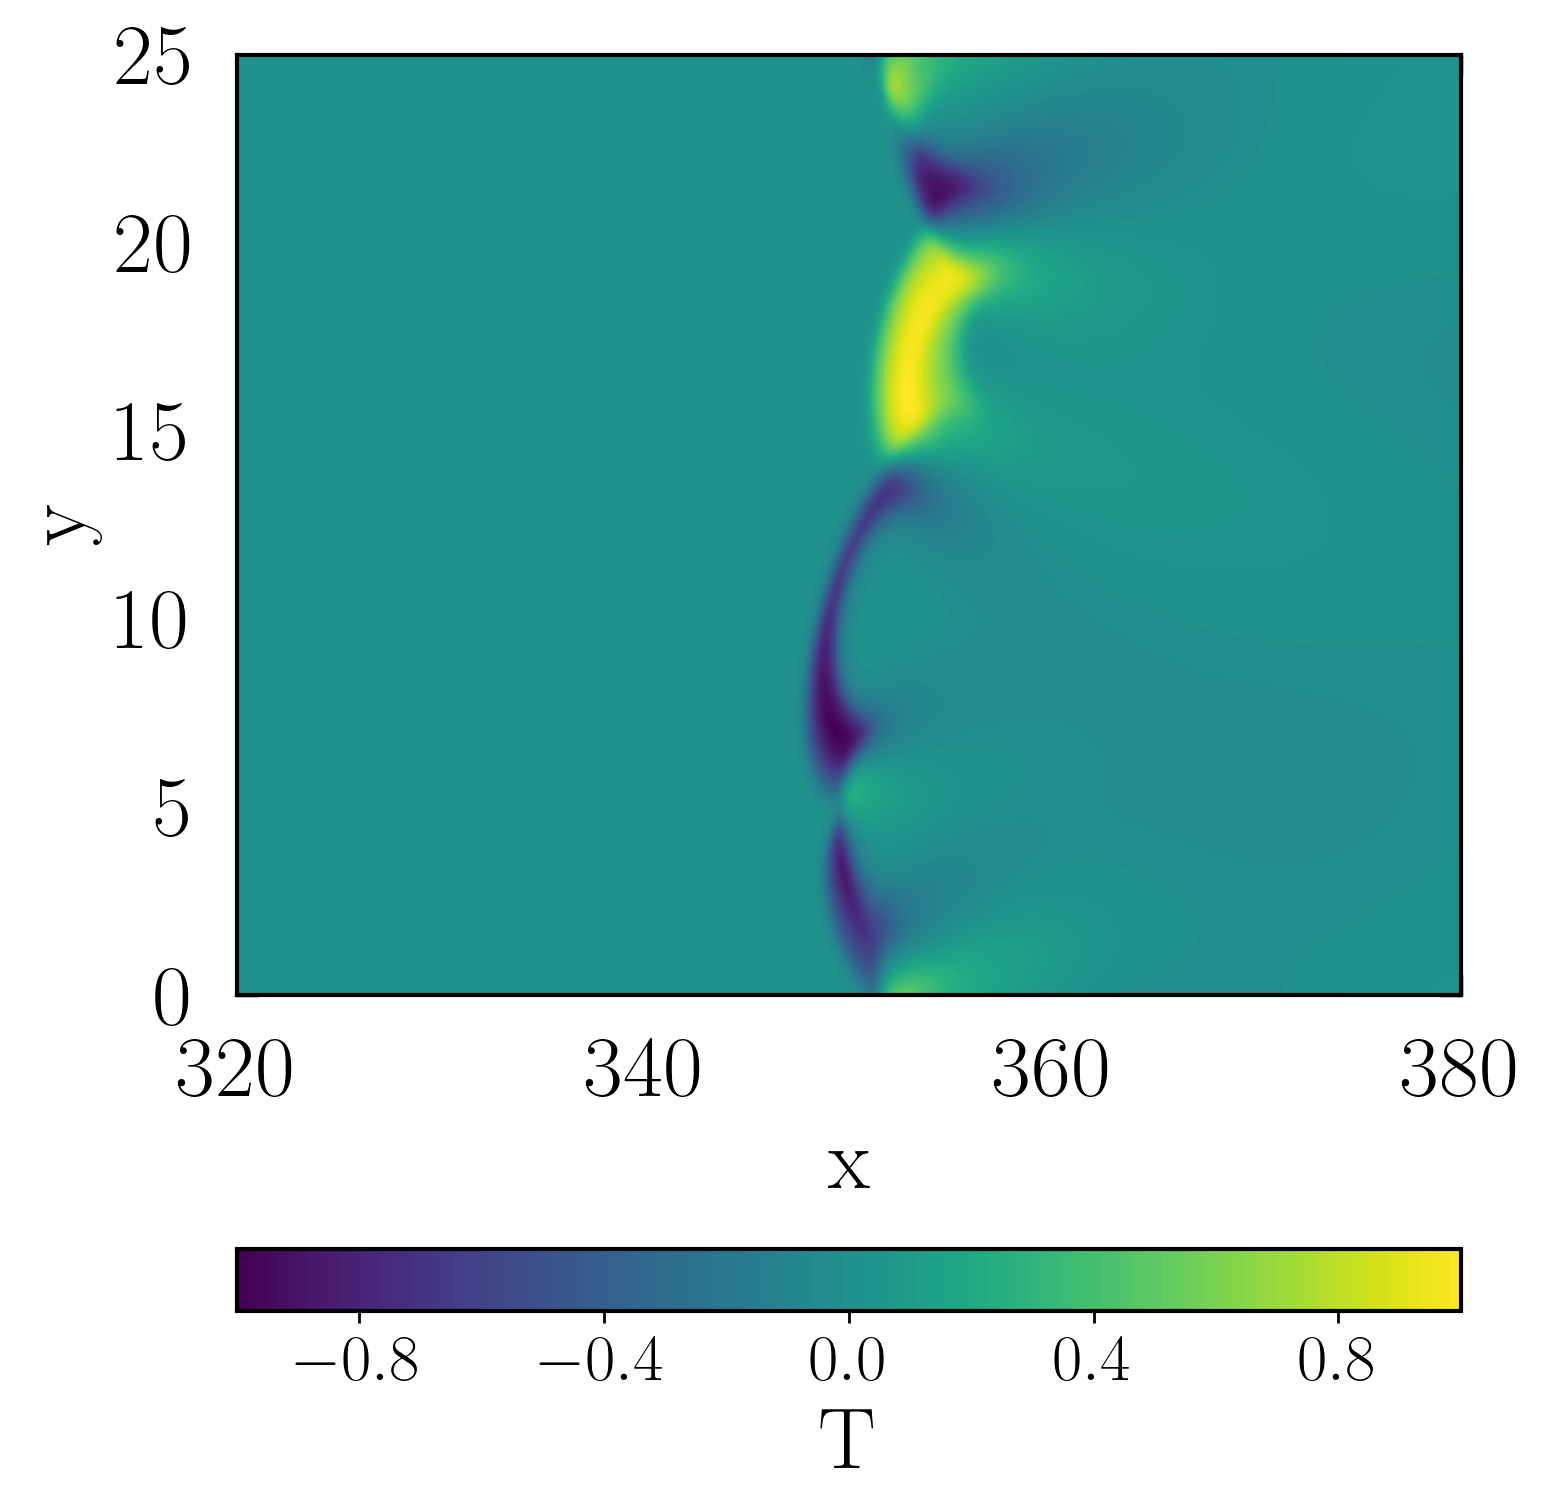

/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772a704ddf40>' will be ignored
  cf.set_rasterized(True)


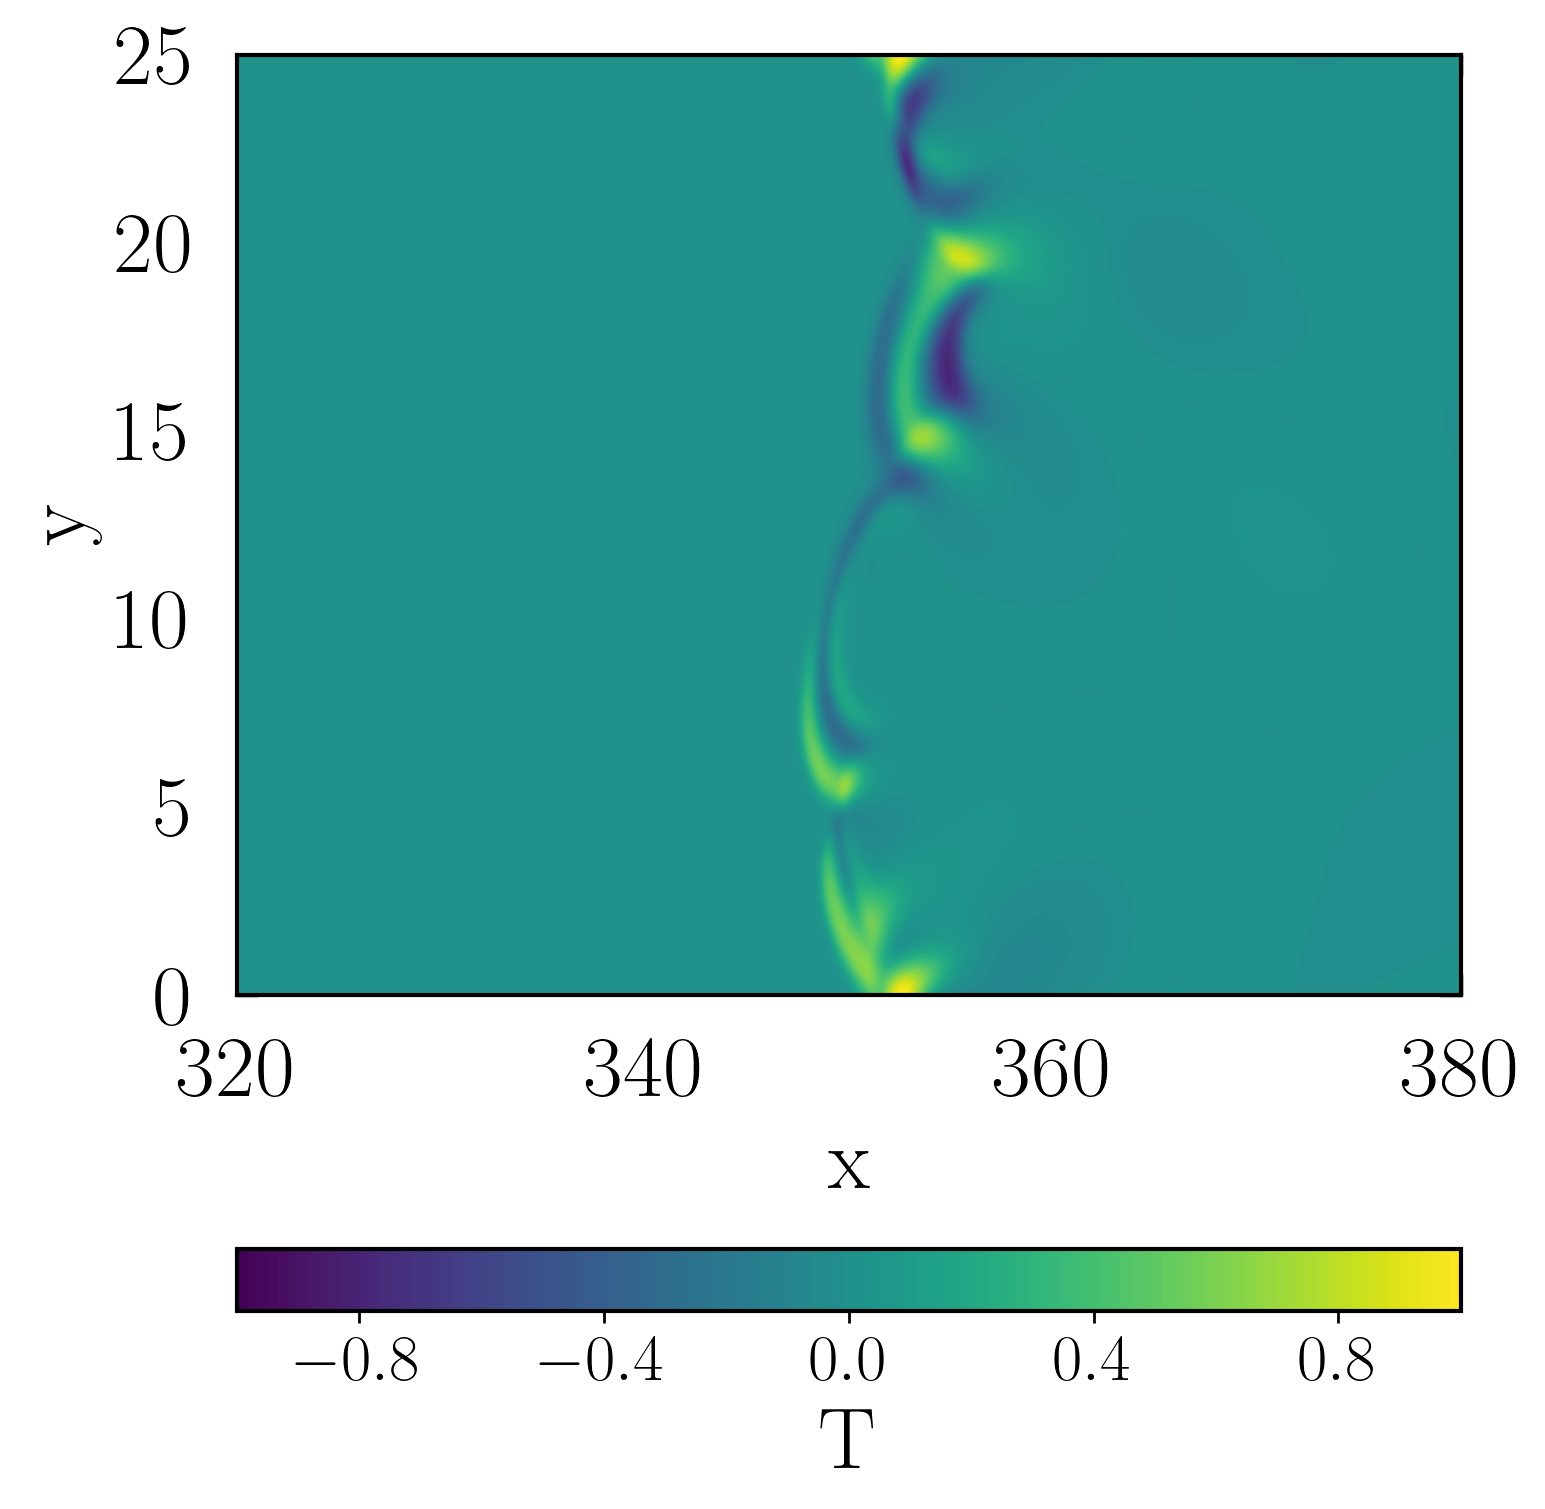

/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772aac58b2f0>' will be ignored
  cf.set_rasterized(True)


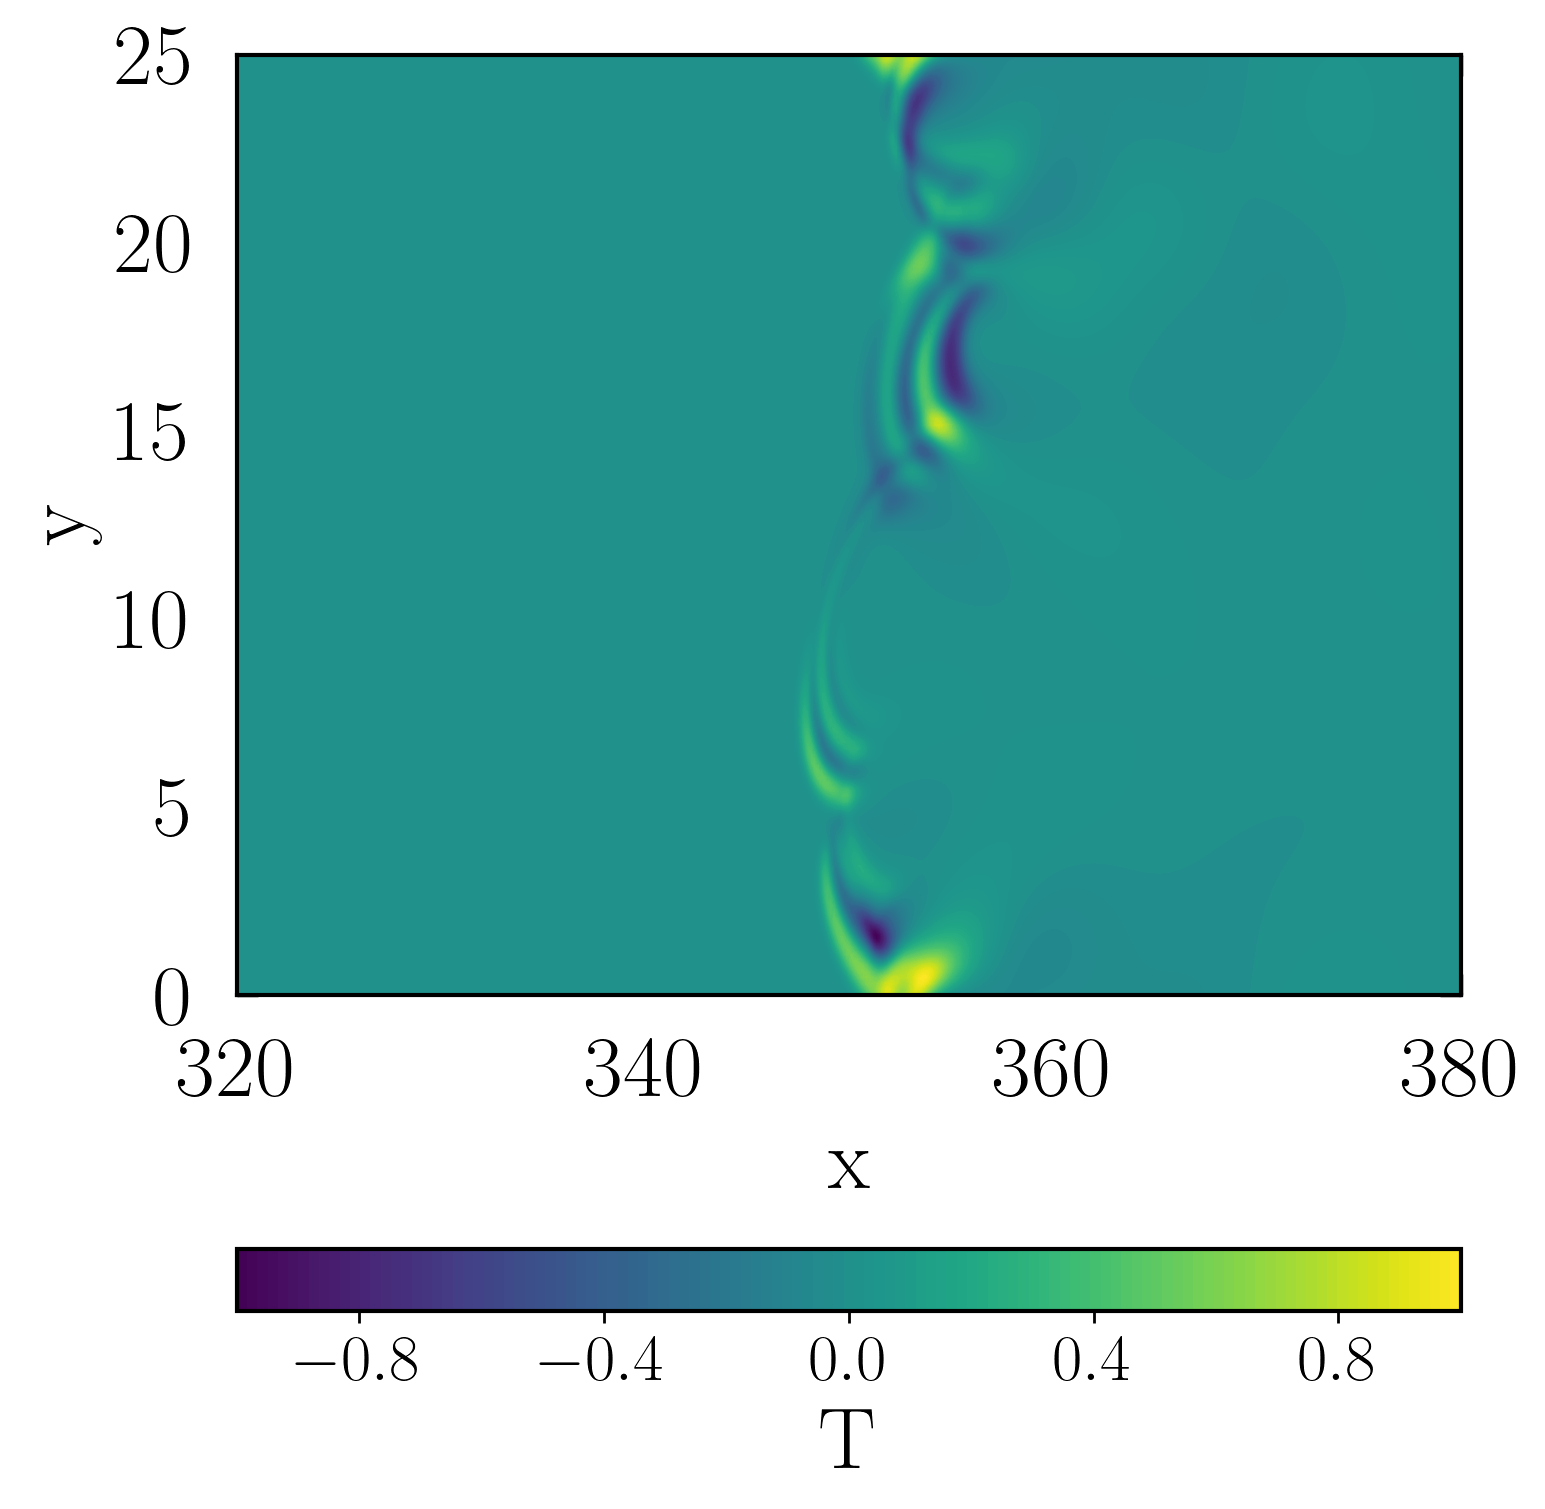

/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772a6a02b650>' will be ignored
  cf.set_rasterized(True)


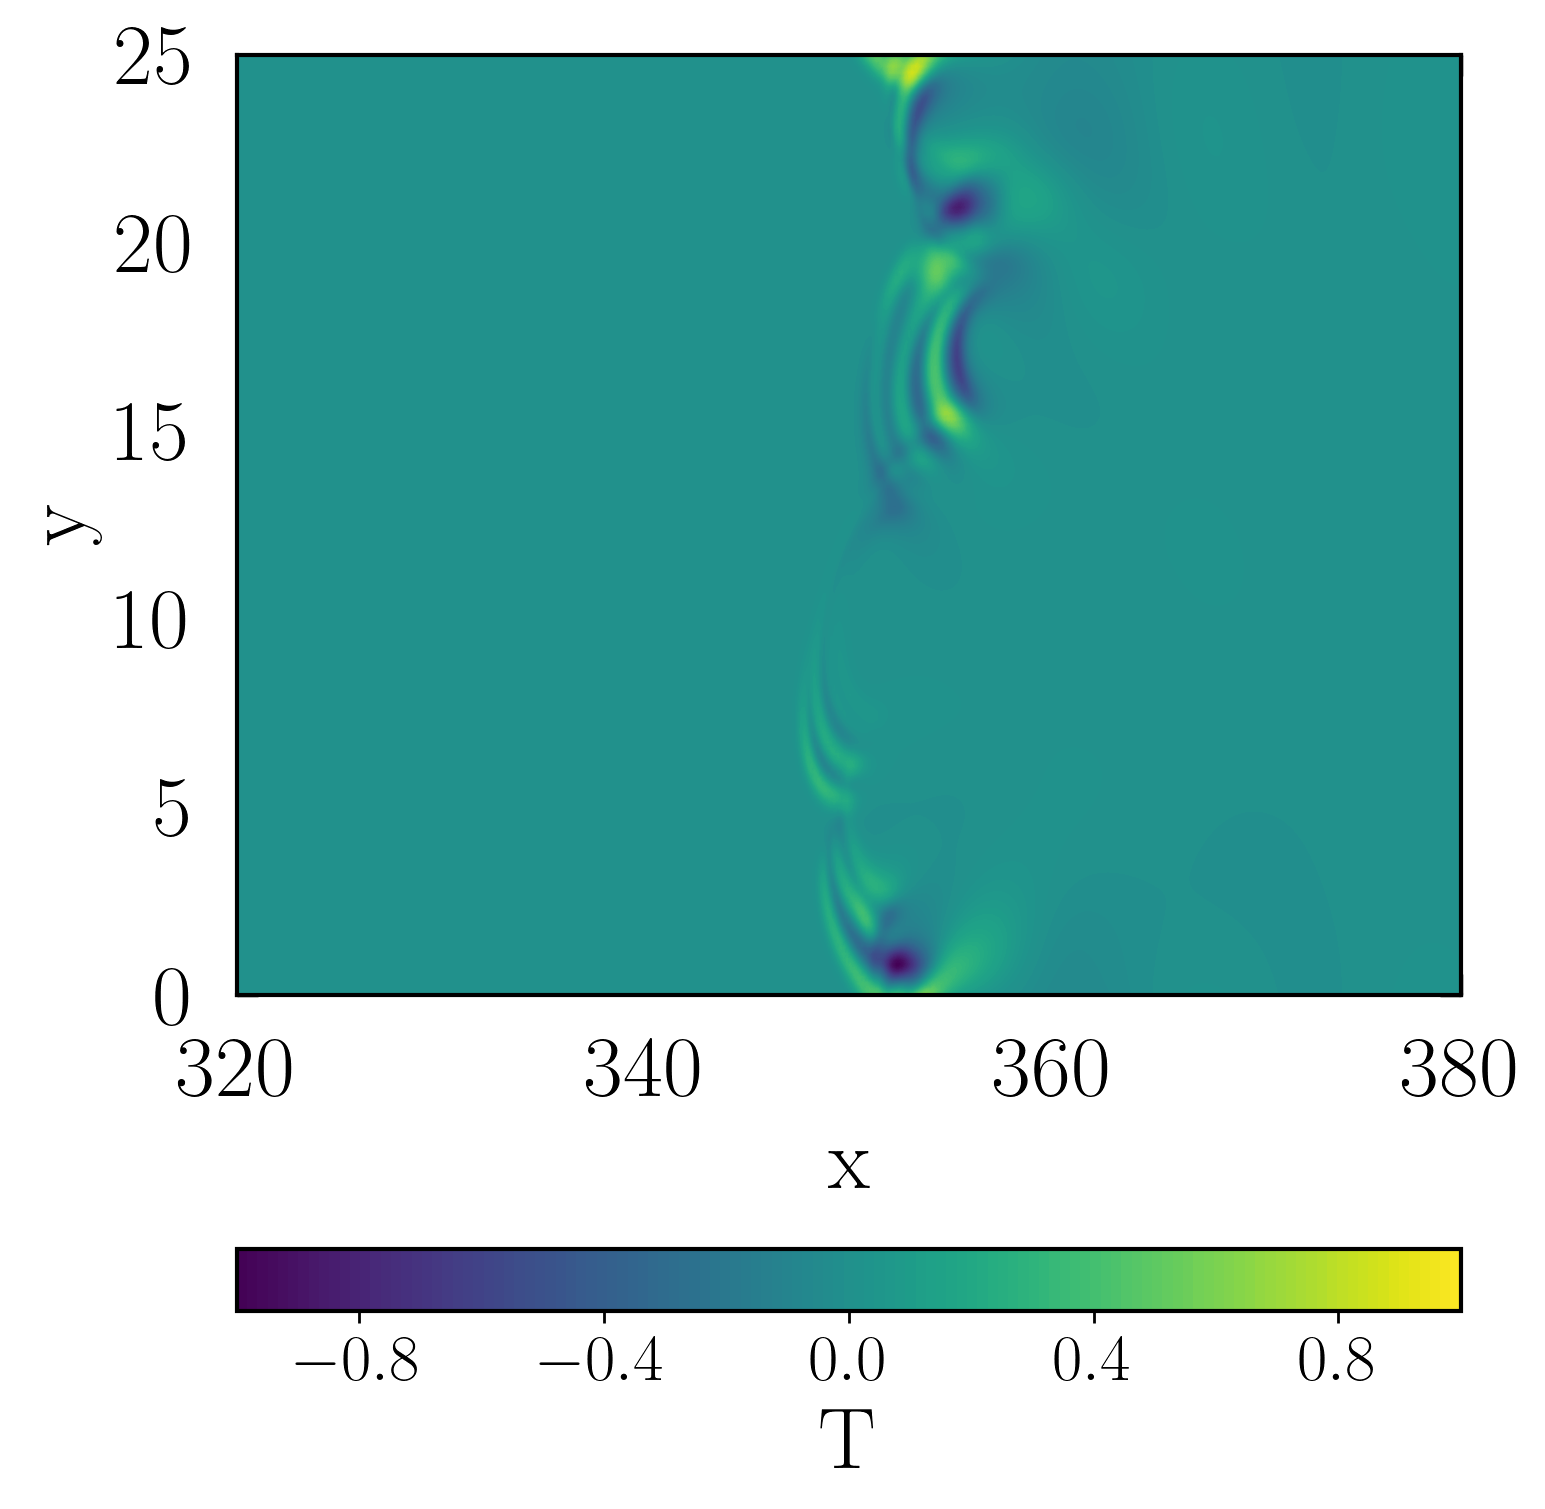

/tmp/ipykernel_13769/823386022.py:282: UserWarning: linewidths is ignored by contourf
  cf = ax.tricontourf(tri, x_next_pred, levels=pred_true_levels, vmin=joint_min, vmax=joint_max, antialiased=False, linewidths=0)
/tmp/ipykernel_13769/823386022.py:4: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x772a7022c4a0>' will be ignored
  cf.set_rasterized(True)


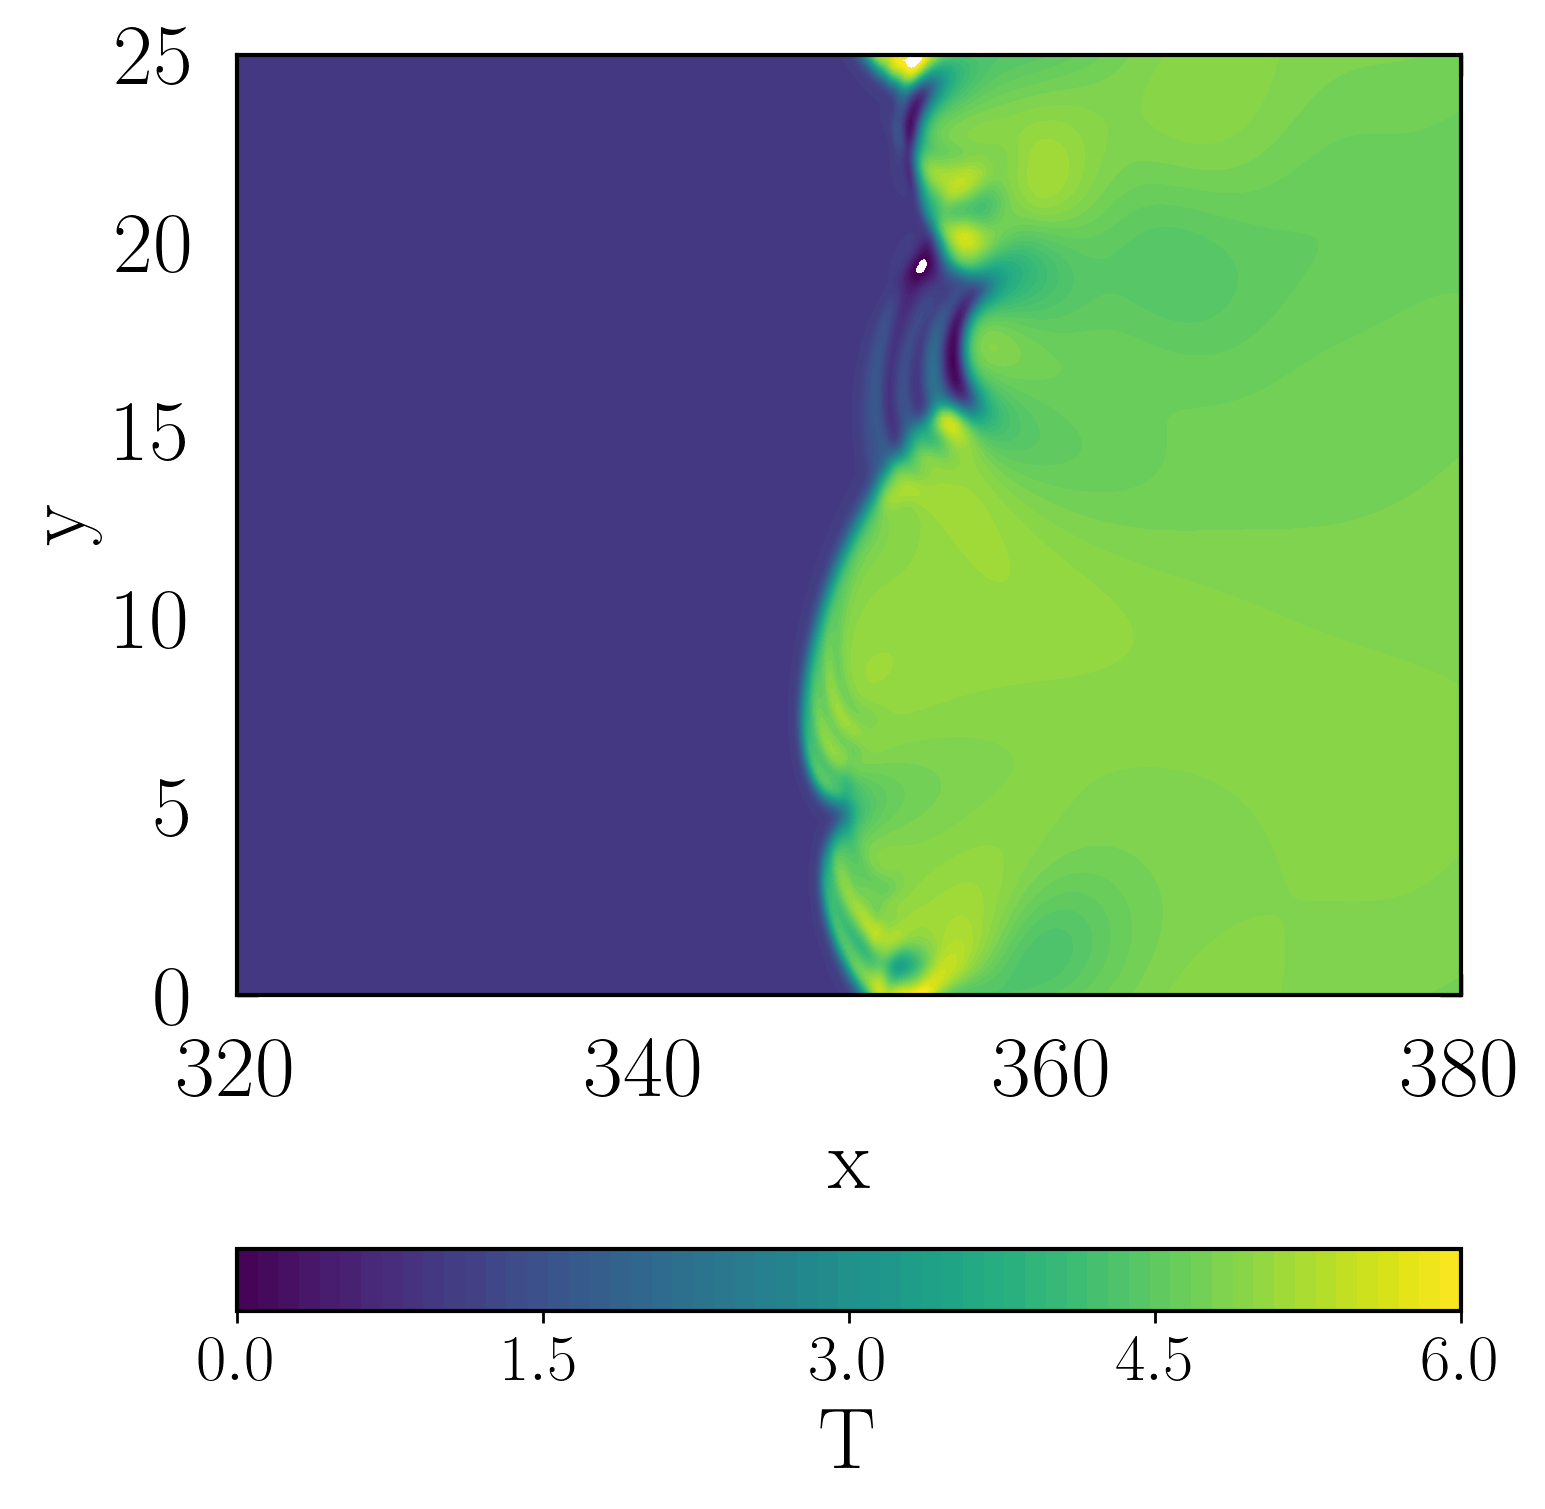

In [7]:
def _fix_tricontourf(cf):
    """Remove edge seams in vector outputs."""
    if hasattr(cf, "set_rasterized"):
        cf.set_rasterized(True)
    collections = getattr(cf, "collections", None)
    if collections is None:
        collections = getattr(cf, "artists", None)
    if collections is None:
        try:
            collections = cf.get_children()
        except Exception:
            collections = []
    for coll in collections:
        if hasattr(coll, "set_edgecolor"):
            coll.set_edgecolor("none")
        if hasattr(coll, "set_linewidth"):
            coll.set_linewidth(0.0)
        if hasattr(coll, "set_antialiased"):
            coll.set_antialiased(False)

from FLAME.io_fields import field_path, FIELD_HDF_KEY
from FLAME.io_fronts import Case

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ------------------------------------------------------------
# 1) Forecast next snapshot with consistent index-time
# ------------------------------------------------------------
n_train = X.shape[1]
t_next = TIME_STEP_END + 1  # keep consistent everywhere

out_dir = field_path(Case(base_dir=BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=0, post=POST)).parent
out_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 2) Build triangulation ONCE for CROPPED coords (for all XY maps)
# ------------------------------------------------------------
x = coords_ref[:, 0].astype(float)
y = coords_ref[:, 1].astype(float)
tri = mtri.Triangulation(x, y)

# Optional: mask skinny triangles (helps avoid artifacts)
try:
    analyzer = mtri.TriAnalyzer(tri)
    mask = analyzer.get_flat_tri_mask(min_circle_ratio=0.02)
    tri.set_mask(mask)
except Exception:
    pass

# ------------------------------------------------------------
# 2B) Build boundary mappings for BC metrics
# ------------------------------------------------------------
x_min = float(np.min(x))
x_max = float(np.max(x))
y_min = float(np.min(y))
y_max = float(np.max(y))

x_span = float(np.ptp(x)) or 1.0
y_span = float(np.ptp(y)) or 1.0
bc_tol_x = 1e-6 * x_span
bc_tol_y = 1e-6 * y_span

left_idx = np.where(np.isclose(x, x_min, atol=bc_tol_x))[0]
right_idx = np.where(np.isclose(x, x_max, atol=bc_tol_x))[0]
top_idx = np.where(np.isclose(y, y_max, atol=bc_tol_y))[0]
bottom_idx = np.where(np.isclose(y, y_min, atol=bc_tol_y))[0]

left_target = None
if left_idx.size:
    left_target = float(np.mean(X[left_idx, :]))

top_bottom_pairs = []
if top_idx.size and bottom_idx.size:
    for i in top_idx:
        dx = np.abs(x[bottom_idx] - x[i])
        j = bottom_idx[int(np.argmin(dx))]
        if dx.min() <= bc_tol_x:
            top_bottom_pairs.append((i, j))
top_bottom_pairs = np.asarray(top_bottom_pairs, dtype=int)

right_pairs = []
if right_idx.size:
    for i in right_idx:
        same_y = np.where(np.isclose(y, y[i], atol=bc_tol_y) & (x < x_max - bc_tol_x))[0]
        if same_y.size == 0:
            continue
        j = same_y[np.argmax(x[same_y])]
        if x[i] - x[j] > 0:
            right_pairs.append((i, j))
right_pairs = np.asarray(right_pairs, dtype=int)

def _bc_metrics(values):
    metrics = {}
    if left_idx.size:
        left_vals = values[left_idx]
        if left_target is not None:
            metrics["dirichlet_left_rmse"] = float(np.sqrt(np.mean((left_vals - left_target) ** 2)))
        metrics["dirichlet_left_std"] = float(np.std(left_vals))
    if right_pairs.size:
        dx = x[right_pairs[:, 0]] - x[right_pairs[:, 1]]
        valid = dx > 0
        if np.any(valid):
            diff = (values[right_pairs[:, 0]] - values[right_pairs[:, 1]])[valid]
            grad = diff / dx[valid]
            metrics["neumann_right_rms"] = float(np.sqrt(np.mean(grad ** 2)))
    if top_bottom_pairs.size:
        diff = values[top_bottom_pairs[:, 0]] - values[top_bottom_pairs[:, 1]]
        metrics["periodic_top_bottom_rms"] = float(np.sqrt(np.mean(diff ** 2)))
    return metrics

# ------------------------------------------------------------
# 3) Load true next snapshot (if available) ONCE
# ------------------------------------------------------------
path_true = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)
snap_true = None

if path_true.exists():
    # Read TRUE snapshot FULL first
    coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)

    # Coordinate check on FULL coords (prevents false mismatch due to masking)
    if coords_true_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_true_full, coords_ref_full)
    if not same:
        raise ValueError(
            "Full coordinates changed; cannot compare directly. "
            "Sorting / interpolation mismatch or mesh changed."
        )

    # Apply SAME mask as training data
    snap_true = snap_true_full[mask_x]

    if snap_true.shape[0] != coords_ref.shape[0]:
        raise RuntimeError("Cropped true snapshot size does not match training size. Check mask_x usage.")

PREDICTION_RESULTS = {}

for case_key in CASE_ORDER:
    remove_mean = CASE_REMOVE_MEAN[case_key]
    dmd_case = dmd_by_case[case_key]
    case_plot_dir = OUT_DIR / case_key
    case_plot_dir.mkdir(parents=True, exist_ok=True)

    dmd_case.original_time["t0"] = 0
    dmd_case.original_time["tend"] = n_train - 1
    dmd_case.original_time["dt"] = 1.0

    dmd_case.dmd_time["t0"] = 0
    dmd_case.dmd_time["tend"] = n_train          # +1 step forecast
    dmd_case.dmd_time["dt"] = 1.0

    X_rec = dmd_case.reconstructed_data          # shape: (n_points_cropped, n_train+1)
    if remove_mean:
        X_rec = X_rec + X_mean
    x_next_pred = np.asarray(X_rec[:, -1]).real

    bc = _bc_metrics(x_next_pred)
    if bc:
        bc_parts = [f"{k}={v:.3e}" for k, v in bc.items()]
        print(f"[{label}] BC metrics: " + ", ".join(bc_parts))
    PREDICTION_RESULTS[case_key] = {
        "x_next_pred": x_next_pred,
        "plot_dir": case_plot_dir,
    }

    # Optional diagnostic: eigenvalue stability
    lam = np.asarray(dmd_case.eigs, dtype=complex)
    label = CASE_LABELS.get(case_key, case_key)
    print(f"[{label}] Unstable modes (|λ|>1):", int(np.sum(np.abs(lam) > 1.0)))
    print(f"[{label}] Max |λ|:", float(np.max(np.abs(lam))))

    # --------------------------------------------------------
    # 4) Save prediction alongside coordinates (CROPPED)
    # --------------------------------------------------------
    out = pd.DataFrame(coords_ref, columns=SORT_COLS)
    out[f"{VAR_NAME}_pred"] = x_next_pred

    out_path = out_dir / f"dmd_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}_{case_key}.csv"
    out.to_csv(out_path, index=False)
    print(f"[{label}] Wrote:", out_path)

    # --------------------------------------------------------
    # 5) Plot selected modes (one figure per mode)
    # --------------------------------------------------------
    modes = np.asarray(dmd_case.modes)
    num_modes = modes.shape[1]

    # Choose modes to plot (1-based). Set to None to use first N_MODES_TO_PLOT.
    MODE_INDICES = [5, 6, 8 ,3, 1]  # e.g., [1, 3, 7]

    def _unique_in_order(seq):
        seen = set()
        out = []
        for x in seq:
            if x in seen:
                continue
            seen.add(x)
            out.append(x)
        return out

    if MODE_INDICES is None:
        plot_indices = list(range(min(N_MODES_TO_PLOT, num_modes)))
    else:
        idx = [int(i) - 1 for i in MODE_INDICES]
        plot_indices = [i for i in _unique_in_order(idx) if 0 <= i < num_modes]
        if len(plot_indices) == 0:
            raise ValueError(
                f"MODE_INDICES={MODE_INDICES} out of range; available modes: 1..{num_modes}"
            )
    print(f"[{label}] Plotting modes:", [i + 1 for i in plot_indices])

    mode_plot_stack = []
    mode_min_vals = []
    mode_max_vals = []
    for mode_idx in plot_indices:
        mode = modes[:, mode_idx]
        mode_real = np.real(mode)
        if NORMALIZE_MODE_FOR_PLOT:
            mode_plot = mode_real / (np.max(np.abs(mode_real)) + 1e-30)
        mode_plot_stack.append(mode_plot.ravel())
        mode_min_vals.append(np.min(mode_plot))
        mode_max_vals.append(np.max(mode_plot))
    if mode_plot_stack:
        mode_plot_stack = np.concatenate(mode_plot_stack)
        mode_vmin_global = float(np.min(mode_plot_stack))
        mode_vmax_global = float(np.max(mode_plot_stack))
        mode_levels = np.linspace(mode_vmin_global, mode_vmax_global, MODE_CONTOUR_LEVELS_FILLED)
    for mode_idx in plot_indices:
        mode = modes[:, mode_idx]
        mode_real = np.real(mode)
        if NORMALIZE_MODE_FOR_PLOT:
            mode_plot = mode_real / (np.max(np.abs(mode_real)) + 1e-30)
        vmin_mode = mode_vmin_global
        vmax_mode = mode_vmax_global

        fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
        ax = fig.add_subplot(111)
        cf = ax.tricontourf(tri, mode_plot, levels=mode_levels, vmin=vmin_mode, vmax=vmax_mode, antialiased=False, linewidths=0)
        _fix_tricontourf(cf)
        style_axes(ax)
        ax.tick_params(axis="both", which="both", pad=12)
        ax.set_xlabel(COORD_X)
        ax.set_ylabel(COORD_Y)
        if XLIM is not None:
            ax.set_xlim(XLIM)
        if YLIM is not None:
            ax.set_ylim(YLIM)
        cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.2, fraction=0.06)
        cbar.set_label("T")
        style_colorbar(cbar)
        save_plot(fig, f"dmd_mode_{VAR_NAME}_idx{mode_idx + 1:02d}", case_plot_dir)
        plt.show()

    # --------------------------------------------------------
    # 6) Plot PREDICTED field at next timestep (always available)
    # --------------------------------------------------------
    vmax_pred = np.percentile(np.abs(x_next_pred), 99.5) + 1e-30
    vmin_pred = np.percentile(x_next_pred, 0.5)
    vmax_pred_lin = np.percentile(x_next_pred, 99.5)

    # Shared range between prediction and ground truth
    # Shared range between prediction and ground truth
    if snap_true is not None:
        joint_min = float(np.min([x_next_pred.min(), snap_true.min()]))
        joint_max = float(np.max([x_next_pred.max(), snap_true.max()]))
    else:
        joint_min = float(x_next_pred.min())
        joint_max = float(x_next_pred.max())
    pred_true_levels = np.linspace(joint_min, joint_max, 60)
    # Shared range between prediction and ground truth
    if snap_true is not None:
        joint_min = float(np.min([x_next_pred.min(), snap_true.min()]))
        joint_max = float(np.max([x_next_pred.max(), snap_true.max()]))
    else:
        joint_min = float(x_next_pred.min())
        joint_max = float(x_next_pred.max())
    pred_true_levels = np.linspace(joint_min, joint_max, 60)
    # Shared range between prediction and ground truth
    if snap_true is not None:
        joint_min = float(np.min([x_next_pred.min(), snap_true.min()]))
        joint_max = float(np.max([x_next_pred.max(), snap_true.max()]))
    else:
        joint_min = float(x_next_pred.min())
        joint_max = float(x_next_pred.max())
    pred_true_levels = np.linspace(joint_min, joint_max, 60)


    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, x_next_pred, levels=pred_true_levels, vmin=joint_min, vmax=joint_max, antialiased=False, linewidths=0)
    _fix_tricontourf(cf)
    style_axes(ax)
    ax.tick_params(axis="both", which="both", pad=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if XLIM is not None:
        ax.set_xlim(XLIM)
    if YLIM is not None:
        ax.set_ylim(YLIM)
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.2, fraction=0.06)
    cbar.set_label("T")
    style_colorbar(cbar)
    save_plot(fig, f"dmd_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}", case_plot_dir)
    plt.show()

    # --------------------------------------------------------
    # 7) Compare to true next snapshot + error metrics + plots
    # --------------------------------------------------------
    # Shared range between prediction and ground truth
    if snap_true is not None:
        joint_min = float(np.min([x_next_pred.min(), snap_true.min()]))
        joint_max = float(np.max([x_next_pred.max(), snap_true.max()]))
    else:
        joint_min = float(x_next_pred.min())
        joint_max = float(x_next_pred.max())
    pred_true_levels = np.linspace(joint_min, joint_max, 60)


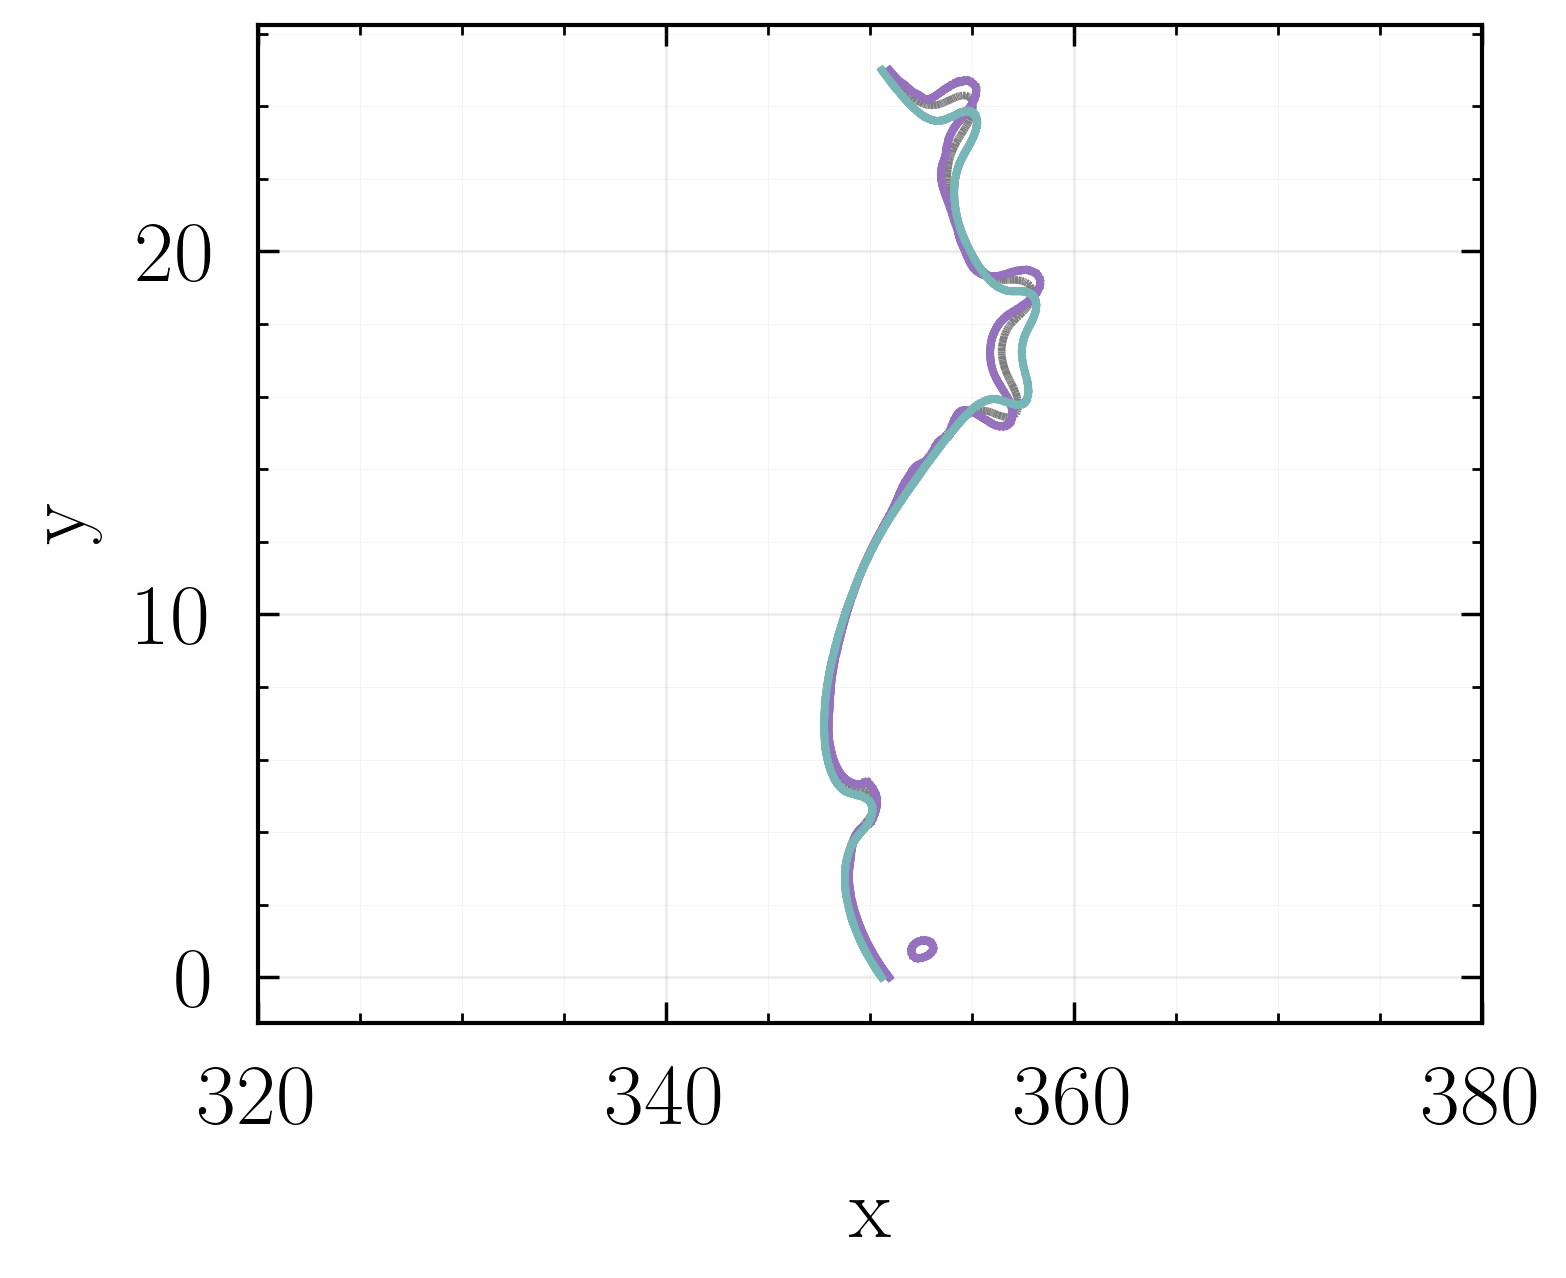

In [8]:
# --- PyVista isocontour comparison (pred / true / prev) ---
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

ISO_VALUE = 3.8  # set desired T isocontour
ISO_FIG_SIZE = (FIG_SIZE[0], FIG_SIZE[1] / 1.18)  # match field plot axes height

def _build_ugrid_xy(coords):
    pts = np.column_stack([
        coords[:, 0].astype(float),
        coords[:, 1].astype(float),
        np.zeros(coords.shape[0], dtype=float),
    ])
    poly = pv.PolyData(pts)
    mesh = poly.delaunay_2d()
    if hasattr(mesh, "cast_to_unstructured_grid"):
        return mesh.cast_to_unstructured_grid()
    return mesh

def _extract_isoline(grid, values, iso_value, label):
    if values.shape[0] != grid.n_points:
        raise ValueError(
            f"Scalar length {values.shape[0]} does not match grid points {grid.n_points}."
        )
    g = grid.copy(deep=True)
    g[label] = values
    return g.contour(isosurfaces=[iso_value], scalars=label)

def _contour_segments_xy(poly):
    if poly.n_points == 0:
        return []
    lines = np.asarray(poly.lines)
    if lines.size == 0:
        return []
    pts = np.asarray(poly.points)
    segments = []
    i = 0
    while i < lines.size:
        n = lines[i]
        idx = lines[i + 1 : i + 1 + n]
        segments.append(pts[idx, :2])
        i += n + 1
    return segments

def _plot_segments(ax, segments, *, label, color, linestyle="-", linewidth=2.2):
    if not segments:
        return False
    first = True
    for seg in segments:
        ax.plot(
            seg[:, 0],
            seg[:, 1],
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
            label=label if first else None,
        )
        first = False
    return True


def _save_plot(fig, stem, plot_dir):
    pad = 0.02
    fig.savefig(plot_dir / f"{stem}.png", dpi=FIG_DPI)
    fig.savefig(plot_dir / f"{stem}.pdf")
    fig.savefig(plot_dir / f"{stem}.svg")

if "PREDICTION_RESULTS" not in locals() or not PREDICTION_RESULTS:
    raise RuntimeError("Run the prediction cell to populate PREDICTION_RESULTS before plotting isocontours.")

# Previous (last training) snapshot
x_prev = np.asarray(X[:, -1]).real

# True next snapshot (if available)
snap_true_iso = None
if "snap_true" in locals() and snap_true is not None:
    snap_true_iso = np.asarray(snap_true).real
else:
    path_true = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)
    if path_true.exists():
        coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)
        if coords_true_full.shape[0] != coords_ref_full.shape[0]:
            raise ValueError(
                f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
            )
        if COORD_TOL == 0.0:
            same = np.array_equal(coords_true_full, coords_ref_full)
        else:
            same = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)
        if not same:
            raise ValueError("Full coordinates changed; cannot compare directly.")
        snap_true_iso = snap_true_full[mask_x]

grid = _build_ugrid_xy(coords_ref)

contour_prev = _extract_isoline(grid, x_prev, ISO_VALUE, f"{VAR_NAME}_prev")
segments_prev = _contour_segments_xy(contour_prev)

segments_true = []
if snap_true_iso is not None:
    contour_true = _extract_isoline(grid, snap_true_iso, ISO_VALUE, f"{VAR_NAME}_true")
    segments_true = _contour_segments_xy(contour_true)

for case_key in CASE_ORDER:
    result = PREDICTION_RESULTS.get(case_key)
    if result is None:
        continue

    x_next_pred = result["x_next_pred"]
    plot_dir = result["plot_dir"]
    label = CASE_LABELS.get(case_key, case_key)

    contour_pred = _extract_isoline(grid, x_next_pred, ISO_VALUE, f"{VAR_NAME}_pred")
    segments_pred = _contour_segments_xy(contour_pred)

    fig = plt.figure(figsize=ISO_FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(bottom=0.2)
    ax = fig.add_subplot(111)

    _plot_segments(ax, segments_prev, label="prev", color=COLOR_NEUTRAL, linestyle="--", linewidth=LINE_WIDTH)
    _plot_segments(ax, segments_pred, label="pred", color=COLOR_PRED, linestyle="-", linewidth=LINE_WIDTH)
    if segments_true:
        _plot_segments(ax, segments_true, label="true", color=COLOR_DATA, linestyle="-", linewidth=LINE_WIDTH)

    ax.tick_params(axis="both", which="both", pad=12)
    ax.set_xlabel(COORD_X, labelpad=10)
    ax.set_ylabel(COORD_Y, labelpad=10)
    # no equal aspect for consistency with field plots
    style_axes(ax)
    if XLIM is not None:
        ax.set_xlim(XLIM)
    if YLIM is not None:
        ax.set_ylim(YLIM)

    _save_plot(fig, f"dmd_isocontour_{VAR_NAME}_{ISO_VALUE:g}_xgt{int(X_THESHOLD)}", plot_dir)
    plt.show()



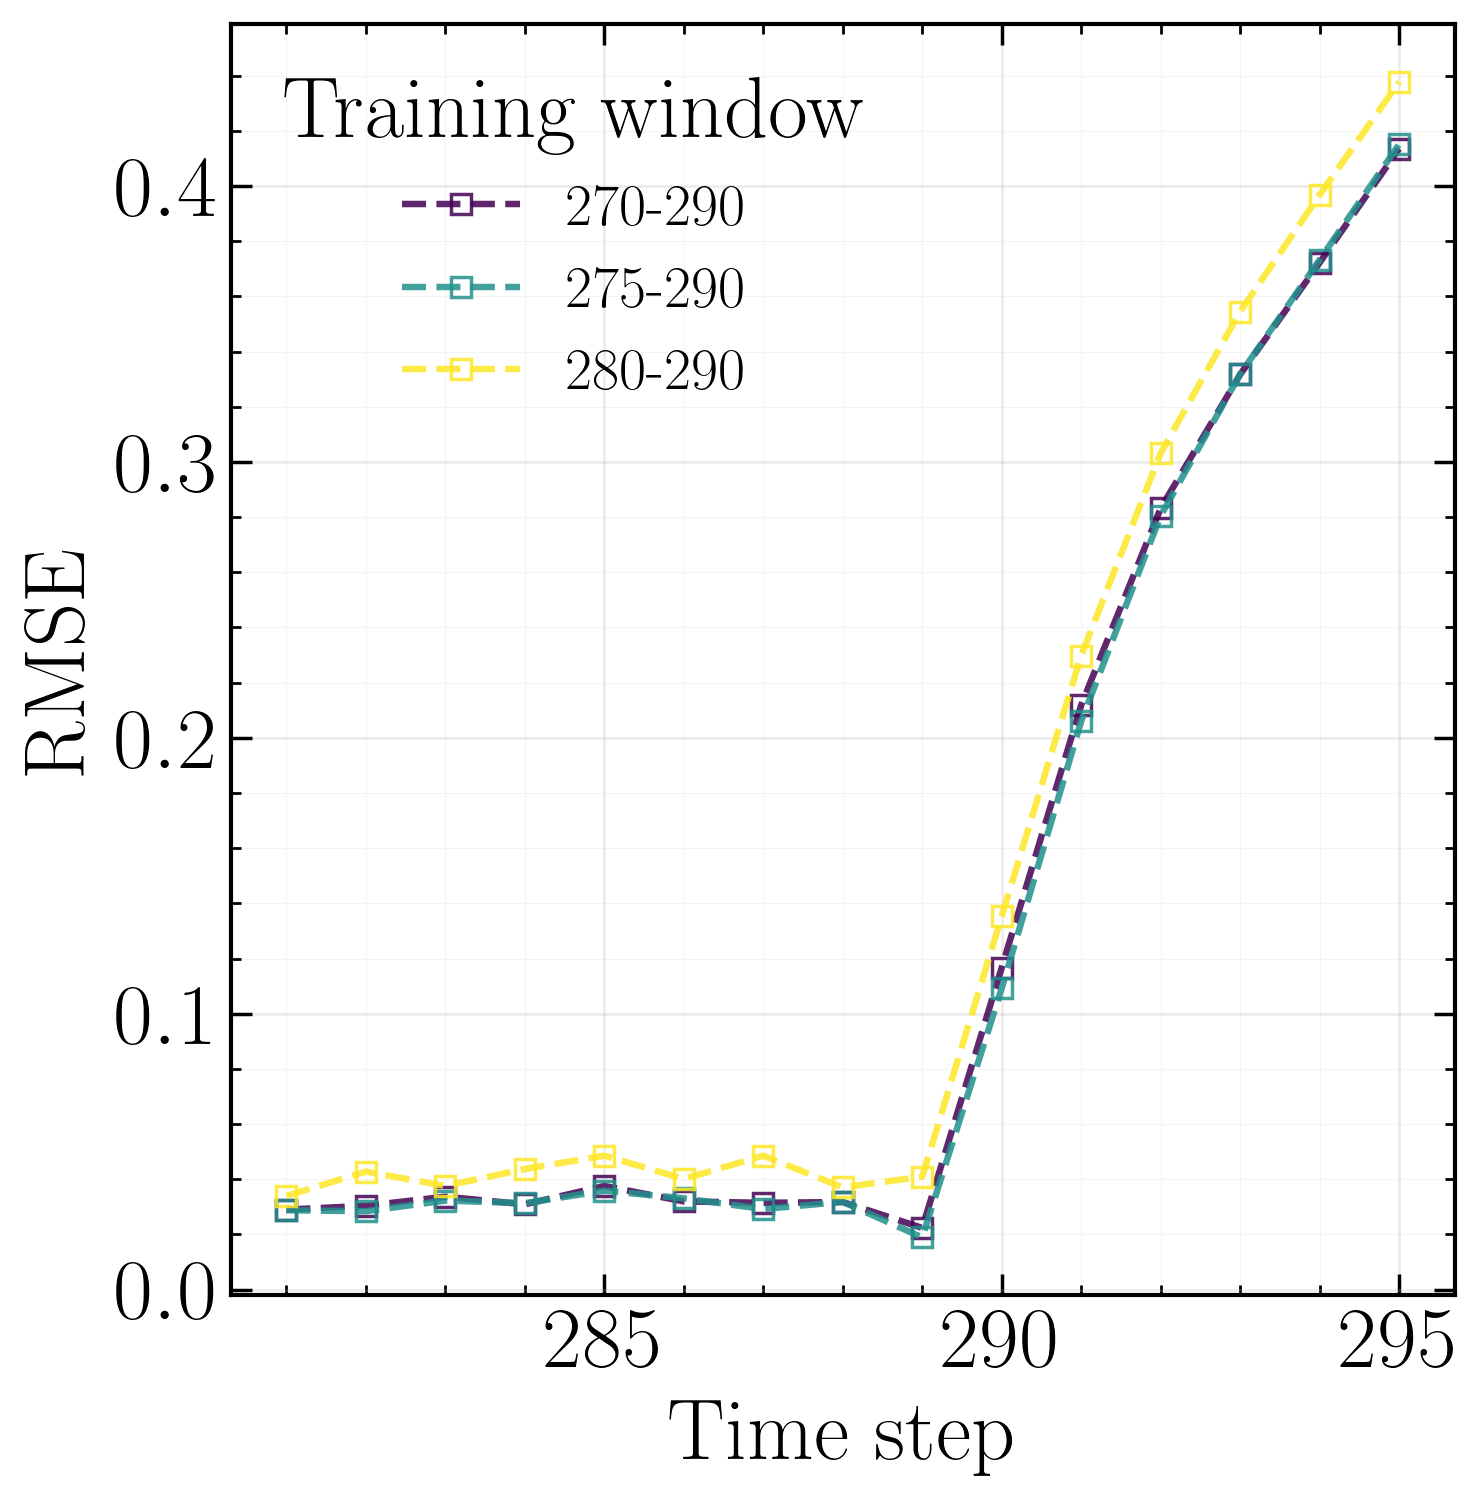

In [9]:
# ------------------------------------------------------------
# Training-window sweep: DMD prediction loss vs time step
# (compare mean-subtracted vs raw snapshots when enabled)
# ------------------------------------------------------------
N_PRED_STEPS = 5
N_PAST_STEPS = 10
TRAIN_END = TIME_STEP_END
TRAIN_START_STEP = 5
MIN_TRAIN_SNAPSHOTS = 10
LOSS_METRIC = "rmse"  # "rmse" or "rel_l2"

# Example override:
# TRAIN_WINDOWS = [(250, 290), (260, 290), (270, 290)]

TRAIN_STARTS = list(range(TIME_STEP_START, TRAIN_END - MIN_TRAIN_SNAPSHOTS + 1, TRAIN_START_STEP))
TRAIN_WINDOWS = [(t0, TRAIN_END) for t0 in TRAIN_STARTS]

try:
    _rank = rank
except NameError:
    _rank = 0

_time_to_idx = {t: i for i, t in enumerate(times)}
_snapshot_cache = {}


def _get_snapshot(t_step):
    if t_step in _time_to_idx:
        return X[:, _time_to_idx[t_step]]
    if t_step in _snapshot_cache:
        return _snapshot_cache[t_step]

    path = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_step, POST)
    if not path.exists():
        return None

    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"Full point count mismatch at timestep {t_step}: {coords_t_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Full coordinates changed at timestep {t_step}; cannot compare without interpolation."
        )

    snap_t = snap_t_full[mask_x]
    _snapshot_cache[t_step] = snap_t
    return snap_t


def _fit_and_predict(X_window, n_pred, remove_mean):
    if remove_mean:
        mean = np.mean(X_window, axis=1, keepdims=True)
        X_in = X_window - mean
    else:
        mean = np.zeros((X_window.shape[0], 1), dtype=X_window.dtype)
        X_in = X_window

    if DMD_SVD_RANK is None:
        dmd_local = DMD()
    else:
        dmd_local = DMD(svd_rank=int(DMD_SVD_RANK))

    dmd_local.fit(X_in)

    n_train = X_window.shape[1]
    dmd_local.original_time["t0"] = 0
    dmd_local.original_time["tend"] = n_train - 1
    dmd_local.original_time["dt"] = 1.0

    dmd_local.dmd_time["t0"] = 0
    dmd_local.dmd_time["tend"] = n_train - 1 + n_pred
    dmd_local.dmd_time["dt"] = 1.0

    X_rec = dmd_local.reconstructed_data
    if remove_mean:
        X_rec = X_rec + mean

    return np.asarray(X_rec).real


def _loss(pred, truth):
    err = pred - truth
    if LOSS_METRIC == "rmse":
        return float(np.sqrt(np.mean(err ** 2)))
    if LOSS_METRIC == "rel_l2":
        return float(np.linalg.norm(err) / (np.linalg.norm(truth) + 1e-30))
    raise ValueError(f"Unknown LOSS_METRIC: {LOSS_METRIC}")


if "CASE_INFO" in locals():
    SWEEP_CASES = CASE_INFO
else:
    if REMOVE_MEAN:
        SWEEP_CASES = [
            {"key": "mean_extracted", "remove_mean": True, "label": "mean extracted"},
            {"key": "no_mean_extracted", "remove_mean": False, "label": "no mean extracted"},
        ]
    else:
        SWEEP_CASES = [
            {"key": "no_mean_extracted", "remove_mean": False, "label": "no mean extracted"},
        ]

results = []

for t_start, t_end in TRAIN_WINDOWS:
    if t_start not in _time_to_idx or t_end not in _time_to_idx:
        if _rank == 0:
            print(f"Skipping window {t_start}-{t_end}: not within loaded times.")
        continue

    if t_end <= t_start:
        if _rank == 0:
            print(f"Skipping window {t_start}-{t_end}: invalid range.")
        continue

    X_window = X[:, _time_to_idx[t_start] : _time_to_idx[t_end] + 1]

    if X_window.shape[1] < max(2, MIN_TRAIN_SNAPSHOTS):
        if _rank == 0:
            print(f"Skipping window {t_start}-{t_end}: too few snapshots.")
        continue

    n_train = X_window.shape[1]
    start_idx = max(0, n_train - N_PAST_STEPS)
    t_train = list(range(t_start + start_idx, t_end + 1))

    eval_times = []
    true_snaps = []
    for k in range(1, N_PRED_STEPS + 1):
        t_eval = t_end + k
        snap_true = _get_snapshot(t_eval)
        if snap_true is None:
            if _rank == 0:
                print(f"Missing true snapshot at timestep {t_eval}; truncating window {t_start}-{t_end}.")
            break
        eval_times.append(t_eval)
        true_snaps.append(snap_true)

    if not eval_times:
        continue

    loss_by_case = {}
    for case in SWEEP_CASES:
        X_rec = _fit_and_predict(X_window, N_PRED_STEPS, remove_mean=case["remove_mean"])

        X_rec_train = X_rec[:, :n_train]
        recon_losses = [_loss(X_rec_train[:, j], X_window[:, j]) for j in range(start_idx, n_train)]

        X_pred = X_rec[:, -N_PRED_STEPS:]
        pred_losses = [_loss(X_pred[:, k], true_snaps[k]) for k in range(len(true_snaps))]

        loss_by_case[case["key"]] = recon_losses + pred_losses

    results.append(
        {
            "window": (t_start, t_end),
            "t": t_train + eval_times,
            "loss_by_case": loss_by_case,
        }
    )

if results:
    apply_plot_style()
    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    ax = fig.add_subplot(111)

    cmap = plt.cm.viridis
    n_curves = len(results)
    for i, res in enumerate(results):
        color = cmap(i / max(1, n_curves - 1))
        base_label = f"{res['window'][0]}-{res['window'][1]}"

        for case in SWEEP_CASES:
            case_key = case["key"]
            if case_key not in res["loss_by_case"]:
                continue

            losses = res["loss_by_case"][case_key]
            if len(SWEEP_CASES) > 1:
                label = f"{base_label} ({case['label']})"
            else:
                label = base_label

            line_width = LINE_WIDTH if case["remove_mean"] else max(1.0, LINE_WIDTH * 0.85)
            linestyle = "-" if case["remove_mean"] else "--"
            marker = "o" if case["remove_mean"] else "s"
            markerface = "white" if case["remove_mean"] else "none"

            ax.plot(
                res["t"],
                losses,
                marker=marker,
                linestyle=linestyle,
                linewidth=line_width,
                color=color,
                alpha=0.85,
                markerfacecolor=markerface,
                markeredgecolor=color,
                markeredgewidth=1.0,
                label=label,
            )

    ax.set_xlabel("Time step")
    ax.set_ylabel("RMSE" if LOSS_METRIC == "rmse" else "Relative L2 error")
    style_axes(ax)

    n_entries = n_curves * max(1, len(SWEEP_CASES))
    ncol = 1 if n_entries <= 6 else 2
    ax.legend(title="Training window", ncol=ncol, frameon=False, fontsize=PLOT_FONT_SIZE - 8)

    if OUT_DIR is not None:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        stem = f"dmd_pred_loss_{LOSS_METRIC}_window_sweep"
        save_plot(fig, stem, OUT_DIR)

    plt.show()
else:
    if _rank == 0:
        print("No valid windows produced predictions. Check TRAIN_WINDOWS and available data.")

